In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
from PIL import Image
from sklearn.naive_bayes import GaussianNB
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

In [3]:
# Training data
training_images = []
training_masks = []
train_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_1/train"

for folder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, folder)
    if os.path.isdir(subfolder_path):
        img_folder = os.path.join(subfolder_path, "img")
        mask_folder = os.path.join(subfolder_path, "mask")
        if os.path.isdir(img_folder) and os.path.isdir(mask_folder):
            for file_name in os.listdir(img_folder):
                img_path = os.path.join(img_folder, file_name)
                mask_path = os.path.join(mask_folder, file_name)  # same name in mask folder
                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    try:
                        img = Image.open(img_path)
                        training_images.append(np.array(img))
                        mask = Image.open(mask_path)
                        training_masks.append(np.array(mask))
                    except Exception as e:
                        print(f"Could not open {img_path} or {mask_path}: {e}")

# Test data
test_images = []
test_masks = []
test_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_1/test"

for folder in os.listdir(test_dir):
    subfolder_path = os.path.join(test_dir, folder)
    if os.path.isdir(subfolder_path):
        img_folder = os.path.join(subfolder_path, "img")
        mask_folder = os.path.join(subfolder_path, "mask")
        if os.path.isdir(img_folder) and os.path.isdir(mask_folder):
            for file_name in os.listdir(img_folder):
                img_path = os.path.join(img_folder, file_name)
                mask_path = os.path.join(mask_folder, file_name)
                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    try:
                        img = Image.open(img_path)
                        test_images.append(np.array(img))
                        mask = Image.open(mask_path)
                        test_masks.append(np.array(mask))
                    except Exception as e:
                        print(f"Could not open {img_path} or {mask_path}: {e}")


In [4]:
training_images = np.array(training_images)
training_masks = np.array(training_masks)
training_masks = (training_masks > 0).astype(np.float32)
test_images = np.array(test_images)
test_masks = np.array(test_masks)
test_masks = (test_masks > 0).astype(np.float32)
print(f"Shape of training images: {training_images.shape}")
print(f"Shape of training masks: {training_masks.shape}")
print(f"Shape of test images: {test_images.shape}")
print(f"Shape of test masks: {test_masks.shape}")
print(f"Maximum value in training images: {np.max(training_images)}")
print(f"Maximum value in test images: {np.max(test_images)}")
print(f"Maximum value in training masks: {np.max(training_masks)}")
print(f"Maximum value in test masks: {np.max(test_masks)}")

Shape of training images: (1847, 128, 128)
Shape of training masks: (1847, 128, 128)
Shape of test images: (947, 128, 128)
Shape of test masks: (947, 128, 128)
Maximum value in training images: 255
Maximum value in test images: 255
Maximum value in training masks: 1.0
Maximum value in test masks: 1.0


In [5]:
def normalize_image(images, method='zscore'):
    normalized = np.empty_like(images, dtype=np.float32)
    for i in range(images.shape[0]):
        img = images[i]
        if method == 'minmax':
            min_val, max_val = np.min(img), np.max(img)
            if max_val != min_val:
                normalized[i] = (img - min_val) / (max_val - min_val)
            else:
                normalized[i] = img  
        elif method == 'zscore':
            mean, std = np.mean(img), np.std(img)
            if std != 0:
                normalized[i] = (img - mean) / std
            else:
                normalized[i] = img  
        else:
            raise ValueError("Method must be 'minmax' or 'zscore'")
    return normalized


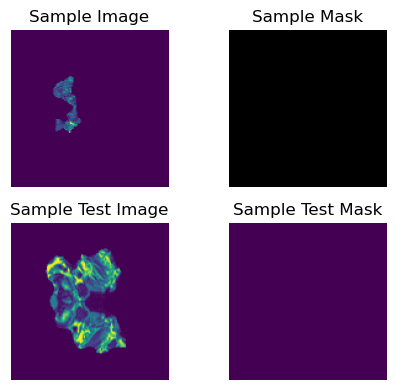

In [6]:
plt.figure(figsize=(6,4))
plt.subplot(2,2,1)
plt.imshow(training_images[0])
plt.title("Sample Image")
plt.axis('off')
plt.tight_layout()
plt.subplot(2,2,2)
plt.imshow(training_masks[0], cmap='gray')
plt.title("Sample Mask")
plt.axis('off')
plt.tight_layout()
plt.subplot(2,2,3)
plt.imshow(test_images[0])
plt.title("Sample Test Image")
plt.axis('off')
plt.tight_layout()
plt.subplot(2,2,4)
plt.imshow(test_masks[0])
plt.title("Sample Test Mask")
plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
train_images_norm = normalize_image(training_images, method='minmax')
test_images_norm = normalize_image(test_images, method='minmax')

In [8]:
X_train = train_images_norm.reshape(-1, 1)  # Pixel intensities
y_train = training_masks.reshape(-1)     # Binary labels (0 or 1)
X_test = test_images_norm.reshape(-1, 1)  # Pixel intensities
y_test = test_masks.reshape(-1)     # Binary labels (0 or 1)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Counts of unique values in y_train: {np.unique(y_train, return_counts=True)}")

Shape of X_train: (30261248, 1)
Shape of y_train: (30261248,)
Shape of X_test: (15515648, 1)
Shape of y_test: (15515648,)
Counts of unique values in y_train: (array([0., 1.], dtype=float32), array([30092814,   168434]))


In [9]:
clf = GaussianNB()
clf.fit(X_train, y_train)


,priors,None
,var_smoothing,1e-09


In [10]:
X_test = test_images_norm.reshape(-1, 1)
y_pred = clf.predict(X_test)
predicted_masks = y_pred.reshape(test_images.shape)
print(f"predicted masks shape {predicted_masks.shape}")

predicted masks shape (947, 128, 128)


In [11]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred) # Element-wise multiplication and sum. If y_true and y_pred are binary masks, this gives the number of pixels that are predicted as positive and are actually positive.
    total = np.sum(y_true) + np.sum(y_pred) # total number of positive pixels in both masks
    if total == 0:
        return 1.0  
    return 2. * intersection / total

def lesion_wise_accuracy(y_true, y_pred):
    true_lesions = np.unique(y_true) # Unique lesion labels in the true mask.
    pred_lesions = np.unique(y_pred) # Unique lesion labels in the predicted mask
    
    true_lesions = true_lesions[true_lesions != 0] # Exclude background (0)
    pred_lesions = pred_lesions[pred_lesions != 0] 
    
    true_positive = 0
    false_negative = len(true_lesions)
    false_positive = len(pred_lesions)
    
    for lesion in true_lesions:
        if lesion in pred_lesions:
            true_positive += 1
            false_negative -= 1
            false_positive -= 1
    
    if (true_positive + false_negative) == 0:
        sensitivity = 1.0
    else:
        sensitivity = true_positive / (true_positive + false_negative) # Recall or Sensitivity
    
    if (true_positive + false_positive) == 0:
        precision = 1.0
    else:
        precision = true_positive / (true_positive + false_positive)
    
    if (precision + sensitivity) == 0:
        f1 = 1.0
    else:
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) # F1 Score(Lesion wise accuracy)
    
    return f1


In [11]:
# Evaluate on each test sample
dice_scores_nb = []
f1_scores_nb = []
lesion_accuracies_nb = []

for i in range(test_images.shape[0]):
    true = test_masks[i].flatten()
    pred = predicted_masks[i].flatten()
    dice_scores_nb.append(dice_score(true, pred))
    f1 = f1_score(true, pred, zero_division=1)
    f1_scores_nb.append(f1)
    lesion_accuracies_nb.append(lesion_wise_accuracy(test_masks[i], predicted_masks[i]))

print(f"Mean Dice Score for Naive Bayes: {np.mean(dice_scores_nb):.4f}")
print(f"Mean F1 Score for Naive Bayes: {np.mean(f1_scores_nb):.4f}")
print(f"Mean Lesion-wise Accuracy for Naive Bayes: {np.mean(lesion_accuracies_nb):.4f}")

Mean Dice Score for Naive Bayes: 0.5016
Mean F1 Score for Naive Bayes: 0.5016
Mean Lesion-wise Accuracy for Naive Bayes: 0.5016


### K-Nearest Neighbour

In [12]:
def sample_data(X, y, sample_size=1000):
    np.random.seed(42)
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]
    n_class_0 = sample_size // 2
    n_class_1 = sample_size - n_class_0
    sample_0 = np.random.choice(class_0_indices, n_class_0, replace=False)
    sample_1 = np.random.choice(class_1_indices, n_class_1, replace=False)
    indices = np.concatenate([sample_0, sample_1])
    np.random.shuffle(indices)
    return X[indices], y[indices]
X_train_NB, y_train_NB = sample_data(X_train, y_train, sample_size=1000)
print(f"Shape of sampled X_train_NB: {X_train_NB.shape}")

Shape of sampled X_train_NB: (1000, 1)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', leaf_size=50, n_jobs=-1, metric='euclidean')
knn.fit(X_train_NB, y_train_NB)
y_pred_knn = knn.predict(X_test)

In [ ]:
dice_scores_knn = []
f1_scores_knn = []
lesion_accuracies_knn = []
predicted_masks_knn = y_pred_knn.reshape(test_images.shape)
for i in range(test_images.shape[0]):
    true = test_masks[i].flatten()
    pred = predicted_masks_knn[i].flatten()
    dice_scores_knn.append(dice_score(true, pred))
    f1 = f1_score(true, pred, zero_division=1)
    f1_scores_knn.append(f1)
    lesion_accuracies_knn.append(lesion_wise_accuracy(test_masks[i], predicted_masks_knn[i]))

print(f"Mean Dice Score for KNN: {np.mean(dice_scores_knn):.4f}")
print(f"Mean F1 Score for KNN: {np.mean(f1_scores_knn):.4f}")
print(f"Mean Lesion-wise Accuracy for KNN: {np.mean(lesion_accuracies_knn):.4f}")

Mean Dice Score for KNN: 0.1200
Mean F1 Score for KNN: 0.1200
Mean Lesion-wise Accuracy for KNN: 19.8000


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_NB, y_train_NB)
y_pred_rf = rf.predict(X_test)

In [ ]:
dice_scores_rf = []
f1_scores_rf = []
lesion_accuracies_rf = []
predicted_masks_rf = y_pred_rf.reshape(test_images.shape)
for i in range(test_images.shape[0]):
    true = test_masks[i].flatten()
    pred = predicted_masks_rf[i].flatten()
    dice_scores_rf.append(dice_score(true, pred))
    f1 = f1_score(true, pred, zero_division=1)
    f1_scores_rf.append(f1)
    lesion_accuracies_rf.append(lesion_wise_accuracy(test_masks[i], predicted_masks_rf[i]))
print(f"Mean Dice Score for Random Forest: {np.mean(dice_scores_rf):.4f}")
print(f"Mean F1 Score for Random Forest: {np.mean(f1_scores_rf):.4f}")
print(f"Mean Lesion-wise Accuracy for Random Forest: {np.mean(lesion_accuracies_rf):.4f}")

Mean Dice Score for Random Forest: 0.0891
Mean F1 Score for Random Forest: 0.0891
Mean Lesion-wise Accuracy for Random Forest: 0.1130


In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

DEVICE = device

### U-net

In [15]:
class DoubleConv(nn.Module): # Convolutional block with two convolutional layers followed by ReLU activations.
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,x):
        return self.conv_op(x)
    
class DownSample(nn.Module): # Downsampling block with DoubleConv followed by MaxPooling. Returns both the output before pooling and after pooling.
    def  __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p # p is used for next layer input and down for skip connection
class UpSample(nn.Module): # Upsampling block with ConvTranspose2d followed by DoubleConv. Takes two inputs for skip connections.
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2 , kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels,out_channels)
    
    def forward(self,x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2],dim=1) # Concatenate along channel dimension. x1 is the upsampled tensor and x2 is the skip connection tensor.
        return self.conv(x)

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes, depth=[False, False, False, False]):
        super().__init__()
        self.depth = depth

        # Encoder depth will be controlled by depth list
        self.down_convolution_1 = DownSample(in_channels, 64)
        if depth[0]:
            self.extra_conv1 = DoubleConv(64, 64) #If I want to add extra conv layers in encoder, I will not change the numbers of channels so that next layers work properly without size mismatch.

        self.down_convolution_2 = DownSample(64, 128)
        if depth[1]:
            self.extra_conv2 = DoubleConv(128, 128)

        self.down_convolution_3 = DownSample(128, 256)
        if depth[2]:
            self.extra_conv3 = DoubleConv(256, 256)

        self.down_convolution_4 = DownSample(256, 512)
        if depth[3]:
            self.extra_conv4 = DoubleConv(512, 512)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        # Output
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        down_1, p1 = self.down_convolution_1(x)
        if self.depth[0]:
            down_1 = self.extra_conv1(down_1) # If extra convolutional layers are added in encoder then updating down_1 for next layer. 
        down_2, p2 = self.down_convolution_2(p1)
        if self.depth[1]:
            down_2 = self.extra_conv2(down_2)

        down_3, p3 = self.down_convolution_3(p2)
        if self.depth[2]:
            down_3 = self.extra_conv3(down_3)

        down_4, p4 = self.down_convolution_4(p3)
        if self.depth[3]:
            down_4 = self.extra_conv4(down_4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out


In [17]:
train_images_tensor = torch.tensor(train_images_norm, dtype=torch.float32).unsqueeze(1)
train_masks_tensor = torch.tensor(training_masks, dtype=torch.float32).unsqueeze(1)
test_images_tensor = torch.tensor(test_images_norm, dtype=torch.float32).unsqueeze(1)
test_masks_tensor = torch.tensor(test_masks, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(train_images_tensor, train_masks_tensor)
test_dataset = TensorDataset(test_images_tensor, test_masks_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [74]:
# Training loop
def trainer_class(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, patience_counter, depth_added = False, scheduler=None):
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    train_dice_scores = []
    valid_dice_scores = []
    patience = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        validation_loss = 0.0
        dice = 0.0
        for batch_idx, (images, masks) in enumerate(tqdm.tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}")):
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images) #logits 
            # print(f"masks shape: {masks.shape}, outputs shape: {outputs.shape}")
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            preds = outputs > 0.5
            train_loss += loss.item() * images.size(0)
            dice+= dice_score(masks.cpu().numpy(), preds.cpu().numpy())
        epoch_train_loss = train_loss / len(train_loader.dataset)
        training_losses.append(epoch_train_loss)
        epoch_dice_score = dice / len(train_loader.dataset)
        train_dice_scores.append(epoch_dice_score)
        # Validation
        model.eval()
        with torch.no_grad():
            for images, masks in tqdm.tqdm(test_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                # print(f"masks shape: {masks.shape}, outputs shape: {outputs.shape}")
                loss = criterion(outputs, masks)
                validation_loss += loss.item() * images.size(0)
                dice += dice_score(masks.cpu().numpy(), (outputs > 0.5).cpu().numpy())
        epoch_val_loss = validation_loss / len(test_loader.dataset)
        validation_losses.append(epoch_val_loss)
        epoch_dice_score_val = dice / len(test_loader.dataset)
        valid_dice_scores.append(epoch_dice_score_val)
        if not depth_added:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience = 0
        else:
            patience += 1
        if patience >= patience_counter:
            print("Early stopping triggered")
            break
        if scheduler:
            scheduler.step(epoch_val_loss)
    return training_losses, validation_losses, train_dice_scores, valid_dice_scores

In [19]:
model_exp1 = UNet(in_channels=1, num_classes=1)
model_exp1 = model_exp1.to(DEVICE)
criterion_bce = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_exp1.parameters(), lr=0.0001, weight_decay=1e-5)
num_epochs = 100
patience_counter = 5

In [20]:
training_losses, validation_losses, train_dice_scores, valid_dice_scores = trainer_class(model_exp1, train_loader, test_loader, criterion_bce, optimizer, num_epochs, device, patience_counter)

Validation Epoch 1/100: 100%|██████████| 30/30 [00:01<00:00, 28.75it/s]


Epoch 1/100, Train Loss: 0.5247, Val Loss: 0.4213


Validation Epoch 2/100: 100%|██████████| 30/30 [00:01<00:00, 29.58it/s]


Epoch 2/100, Train Loss: 0.3729, Val Loss: 0.3659


Validation Epoch 3/100: 100%|██████████| 30/30 [00:01<00:00, 29.67it/s]


Epoch 3/100, Train Loss: 0.3323, Val Loss: 0.3213


Validation Epoch 4/100: 100%|██████████| 30/30 [00:01<00:00, 29.09it/s]


Epoch 4/100, Train Loss: 0.3034, Val Loss: 0.2945


Validation Epoch 5/100: 100%|██████████| 30/30 [00:01<00:00, 29.52it/s]


Epoch 5/100, Train Loss: 0.2752, Val Loss: 0.2651


Validation Epoch 6/100: 100%|██████████| 30/30 [00:01<00:00, 29.54it/s]


Epoch 6/100, Train Loss: 0.2523, Val Loss: 0.2404


Validation Epoch 7/100: 100%|██████████| 30/30 [00:01<00:00, 29.90it/s]


Epoch 7/100, Train Loss: 0.2312, Val Loss: 0.2255


Validation Epoch 8/100: 100%|██████████| 30/30 [00:01<00:00, 29.52it/s]


Epoch 8/100, Train Loss: 0.2121, Val Loss: 0.2037


Validation Epoch 9/100: 100%|██████████| 30/30 [00:01<00:00, 29.57it/s]


Epoch 9/100, Train Loss: 0.1943, Val Loss: 0.1871


Validation Epoch 10/100: 100%|██████████| 30/30 [00:01<00:00, 29.93it/s]


Epoch 10/100, Train Loss: 0.1779, Val Loss: 0.1717


Validation Epoch 11/100: 100%|██████████| 30/30 [00:01<00:00, 29.75it/s]


Epoch 11/100, Train Loss: 0.1643, Val Loss: 0.1540


Validation Epoch 12/100: 100%|██████████| 30/30 [00:01<00:00, 29.62it/s]


Epoch 12/100, Train Loss: 0.1510, Val Loss: 0.1473


Validation Epoch 13/100: 100%|██████████| 30/30 [00:01<00:00, 29.82it/s]


Epoch 13/100, Train Loss: 0.1392, Val Loss: 0.1324


Validation Epoch 14/100: 100%|██████████| 30/30 [00:01<00:00, 29.96it/s]


Epoch 14/100, Train Loss: 0.1291, Val Loss: 0.1241


Validation Epoch 15/100: 100%|██████████| 30/30 [00:01<00:00, 28.96it/s]


Epoch 15/100, Train Loss: 0.1193, Val Loss: 0.1132


Validation Epoch 16/100: 100%|██████████| 30/30 [00:01<00:00, 29.38it/s]


Epoch 16/100, Train Loss: 0.1106, Val Loss: 0.1048


Validation Epoch 17/100: 100%|██████████| 30/30 [00:01<00:00, 29.45it/s]


Epoch 17/100, Train Loss: 0.1026, Val Loss: 0.0963


Validation Epoch 18/100: 100%|██████████| 30/30 [00:01<00:00, 29.82it/s]


Epoch 18/100, Train Loss: 0.0953, Val Loss: 0.0899


Validation Epoch 19/100: 100%|██████████| 30/30 [00:01<00:00, 29.45it/s]


Epoch 19/100, Train Loss: 0.0881, Val Loss: 0.0831


Validation Epoch 20/100: 100%|██████████| 30/30 [00:01<00:00, 29.80it/s]


Epoch 20/100, Train Loss: 0.0817, Val Loss: 0.0844


Validation Epoch 21/100: 100%|██████████| 30/30 [00:01<00:00, 29.88it/s]


Epoch 21/100, Train Loss: 0.0756, Val Loss: 0.0818


Validation Epoch 22/100: 100%|██████████| 30/30 [00:01<00:00, 29.40it/s]


Epoch 22/100, Train Loss: 0.0707, Val Loss: 0.0688


Validation Epoch 23/100: 100%|██████████| 30/30 [00:01<00:00, 29.83it/s]


Epoch 23/100, Train Loss: 0.0662, Val Loss: 0.0633


Validation Epoch 24/100: 100%|██████████| 30/30 [00:01<00:00, 29.91it/s]


Epoch 24/100, Train Loss: 0.0617, Val Loss: 0.0590


Validation Epoch 25/100: 100%|██████████| 30/30 [00:01<00:00, 29.87it/s]


Epoch 25/100, Train Loss: 0.0577, Val Loss: 0.0580


Validation Epoch 26/100: 100%|██████████| 30/30 [00:01<00:00, 29.90it/s]


Epoch 26/100, Train Loss: 0.0540, Val Loss: 0.0525


Validation Epoch 27/100: 100%|██████████| 30/30 [00:01<00:00, 29.46it/s]


Epoch 27/100, Train Loss: 0.0507, Val Loss: 0.0509


Validation Epoch 28/100: 100%|██████████| 30/30 [00:01<00:00, 29.73it/s]


Epoch 28/100, Train Loss: 0.0476, Val Loss: 0.0464


Validation Epoch 29/100: 100%|██████████| 30/30 [00:01<00:00, 29.81it/s]


Epoch 29/100, Train Loss: 0.0449, Val Loss: 0.0441


Validation Epoch 30/100: 100%|██████████| 30/30 [00:01<00:00, 29.40it/s]


Epoch 30/100, Train Loss: 0.0423, Val Loss: 0.0428


Validation Epoch 31/100: 100%|██████████| 30/30 [00:01<00:00, 29.40it/s]


Epoch 31/100, Train Loss: 0.0398, Val Loss: 0.0396


Validation Epoch 32/100: 100%|██████████| 30/30 [00:01<00:00, 29.78it/s]


Epoch 32/100, Train Loss: 0.0375, Val Loss: 0.0372


Validation Epoch 33/100: 100%|██████████| 30/30 [00:01<00:00, 29.43it/s]


Epoch 33/100, Train Loss: 0.0355, Val Loss: 0.0358


Validation Epoch 34/100: 100%|██████████| 30/30 [00:01<00:00, 29.79it/s]


Epoch 34/100, Train Loss: 0.0338, Val Loss: 0.0341


Validation Epoch 35/100: 100%|██████████| 30/30 [00:01<00:00, 29.50it/s]


Epoch 35/100, Train Loss: 0.0319, Val Loss: 0.0313


Validation Epoch 36/100: 100%|██████████| 30/30 [00:01<00:00, 29.85it/s]


Epoch 36/100, Train Loss: 0.0304, Val Loss: 0.0307


Validation Epoch 37/100: 100%|██████████| 30/30 [00:01<00:00, 29.85it/s]


Epoch 37/100, Train Loss: 0.0289, Val Loss: 0.0298


Validation Epoch 38/100: 100%|██████████| 30/30 [00:01<00:00, 29.49it/s]


Epoch 38/100, Train Loss: 0.0274, Val Loss: 0.0273


Validation Epoch 39/100: 100%|██████████| 30/30 [00:01<00:00, 26.51it/s]


Epoch 39/100, Train Loss: 0.0259, Val Loss: 0.0270


Validation Epoch 40/100: 100%|██████████| 30/30 [00:01<00:00, 29.90it/s]


Epoch 40/100, Train Loss: 0.0246, Val Loss: 0.0257


Validation Epoch 41/100: 100%|██████████| 30/30 [00:01<00:00, 19.17it/s]


Epoch 41/100, Train Loss: 0.0240, Val Loss: 0.0257


Validation Epoch 42/100: 100%|██████████| 30/30 [00:01<00:00, 29.75it/s]


Epoch 42/100, Train Loss: 0.0230, Val Loss: 0.0244


Validation Epoch 43/100: 100%|██████████| 30/30 [00:01<00:00, 29.15it/s]


Epoch 43/100, Train Loss: 0.0219, Val Loss: 0.0233


Validation Epoch 44/100: 100%|██████████| 30/30 [00:01<00:00, 28.60it/s]


Epoch 44/100, Train Loss: 0.0207, Val Loss: 0.0231


Validation Epoch 45/100: 100%|██████████| 30/30 [00:01<00:00, 29.29it/s]


Epoch 45/100, Train Loss: 0.0198, Val Loss: 0.0215


Validation Epoch 46/100: 100%|██████████| 30/30 [00:01<00:00, 29.39it/s]


Epoch 46/100, Train Loss: 0.0188, Val Loss: 0.0206


Validation Epoch 47/100: 100%|██████████| 30/30 [00:01<00:00, 29.33it/s]


Epoch 47/100, Train Loss: 0.0179, Val Loss: 0.0197


Validation Epoch 48/100: 100%|██████████| 30/30 [00:01<00:00, 29.09it/s]


Epoch 48/100, Train Loss: 0.0172, Val Loss: 0.0200


Validation Epoch 49/100: 100%|██████████| 30/30 [00:01<00:00, 29.53it/s]


Epoch 49/100, Train Loss: 0.0165, Val Loss: 0.0189


Validation Epoch 50/100: 100%|██████████| 30/30 [00:01<00:00, 29.49it/s]


Epoch 50/100, Train Loss: 0.0158, Val Loss: 0.0174


Validation Epoch 51/100: 100%|██████████| 30/30 [00:01<00:00, 29.77it/s]


Epoch 51/100, Train Loss: 0.0152, Val Loss: 0.0175


Validation Epoch 52/100: 100%|██████████| 30/30 [00:01<00:00, 29.22it/s]


Epoch 52/100, Train Loss: 0.0144, Val Loss: 0.0175


Validation Epoch 53/100: 100%|██████████| 30/30 [00:01<00:00, 29.73it/s]


Epoch 53/100, Train Loss: 0.0139, Val Loss: 0.0169


Validation Epoch 54/100: 100%|██████████| 30/30 [00:01<00:00, 28.45it/s]


Epoch 54/100, Train Loss: 0.0132, Val Loss: 0.0162


Validation Epoch 55/100: 100%|██████████| 30/30 [00:01<00:00, 28.90it/s]


Epoch 55/100, Train Loss: 0.0126, Val Loss: 0.0154


Validation Epoch 56/100: 100%|██████████| 30/30 [00:01<00:00, 28.75it/s]


Epoch 56/100, Train Loss: 0.0119, Val Loss: 0.0153


Validation Epoch 57/100: 100%|██████████| 30/30 [00:01<00:00, 27.98it/s]


Epoch 57/100, Train Loss: 0.0117, Val Loss: 0.0153


Validation Epoch 58/100: 100%|██████████| 30/30 [00:01<00:00, 28.58it/s]


Epoch 58/100, Train Loss: 0.0114, Val Loss: 0.0148


Validation Epoch 59/100: 100%|██████████| 30/30 [00:01<00:00, 29.12it/s]


Epoch 59/100, Train Loss: 0.0107, Val Loss: 0.0142


Validation Epoch 60/100: 100%|██████████| 30/30 [00:01<00:00, 29.12it/s]


Epoch 60/100, Train Loss: 0.0103, Val Loss: 0.0137


Validation Epoch 61/100: 100%|██████████| 30/30 [00:01<00:00, 29.51it/s]


Epoch 61/100, Train Loss: 0.0098, Val Loss: 0.0139


Validation Epoch 62/100: 100%|██████████| 30/30 [00:01<00:00, 29.11it/s]


Epoch 62/100, Train Loss: 0.0094, Val Loss: 0.0140


Validation Epoch 63/100: 100%|██████████| 30/30 [00:01<00:00, 28.61it/s]


Epoch 63/100, Train Loss: 0.0088, Val Loss: 0.0134


Validation Epoch 64/100: 100%|██████████| 30/30 [00:01<00:00, 29.12it/s]


Epoch 64/100, Train Loss: 0.0084, Val Loss: 0.0134


Validation Epoch 65/100: 100%|██████████| 30/30 [00:01<00:00, 29.22it/s]


Epoch 65/100, Train Loss: 0.0081, Val Loss: 0.0127


Validation Epoch 66/100: 100%|██████████| 30/30 [00:01<00:00, 29.04it/s]


Epoch 66/100, Train Loss: 0.0078, Val Loss: 0.0127


Validation Epoch 67/100: 100%|██████████| 30/30 [00:01<00:00, 29.13it/s]


Epoch 67/100, Train Loss: 0.0076, Val Loss: 0.0130


Validation Epoch 68/100: 100%|██████████| 30/30 [00:01<00:00, 29.10it/s]


Epoch 68/100, Train Loss: 0.0074, Val Loss: 0.0124


Validation Epoch 69/100: 100%|██████████| 30/30 [00:01<00:00, 29.49it/s]


Epoch 69/100, Train Loss: 0.0071, Val Loss: 0.0122


Validation Epoch 70/100: 100%|██████████| 30/30 [00:01<00:00, 29.10it/s]


Epoch 70/100, Train Loss: 0.0070, Val Loss: 0.0123


Validation Epoch 71/100: 100%|██████████| 30/30 [00:01<00:00, 29.50it/s]


Epoch 71/100, Train Loss: 0.0066, Val Loss: 0.0123


Validation Epoch 72/100: 100%|██████████| 30/30 [00:01<00:00, 29.55it/s]


Epoch 72/100, Train Loss: 0.0062, Val Loss: 0.0124


Validation Epoch 73/100: 100%|██████████| 30/30 [00:01<00:00, 29.38it/s]


Epoch 73/100, Train Loss: 0.0059, Val Loss: 0.0121


Validation Epoch 74/100: 100%|██████████| 30/30 [00:01<00:00, 29.00it/s]


Epoch 74/100, Train Loss: 0.0057, Val Loss: 0.0118


Validation Epoch 75/100: 100%|██████████| 30/30 [00:01<00:00, 29.50it/s]


Epoch 75/100, Train Loss: 0.0056, Val Loss: 0.0115


Validation Epoch 76/100: 100%|██████████| 30/30 [00:01<00:00, 29.39it/s]


Epoch 76/100, Train Loss: 0.0054, Val Loss: 0.0120


Validation Epoch 77/100: 100%|██████████| 30/30 [00:01<00:00, 29.57it/s]


Epoch 77/100, Train Loss: 0.0055, Val Loss: 0.0115


Validation Epoch 78/100: 100%|██████████| 30/30 [00:01<00:00, 29.47it/s]


Epoch 78/100, Train Loss: 0.0050, Val Loss: 0.0113


Validation Epoch 79/100: 100%|██████████| 30/30 [00:01<00:00, 29.42it/s]


Epoch 79/100, Train Loss: 0.0046, Val Loss: 0.0115


Validation Epoch 80/100: 100%|██████████| 30/30 [00:01<00:00, 28.97it/s]


Epoch 80/100, Train Loss: 0.0045, Val Loss: 0.0113


Validation Epoch 81/100: 100%|██████████| 30/30 [00:01<00:00, 29.48it/s]


Epoch 81/100, Train Loss: 0.0043, Val Loss: 0.0115


Validation Epoch 82/100: 100%|██████████| 30/30 [00:01<00:00, 29.49it/s]


Epoch 82/100, Train Loss: 0.0043, Val Loss: 0.0119


Validation Epoch 83/100: 100%|██████████| 30/30 [00:01<00:00, 29.56it/s]


Epoch 83/100, Train Loss: 0.0043, Val Loss: 0.0125


Validation Epoch 84/100: 100%|██████████| 30/30 [00:01<00:00, 29.59it/s]


Epoch 84/100, Train Loss: 0.0041, Val Loss: 0.0113


Validation Epoch 85/100: 100%|██████████| 30/30 [00:01<00:00, 29.62it/s]


Epoch 85/100, Train Loss: 0.0039, Val Loss: 0.0112


Validation Epoch 86/100: 100%|██████████| 30/30 [00:01<00:00, 29.01it/s]


Epoch 86/100, Train Loss: 0.0039, Val Loss: 0.0116


Validation Epoch 87/100: 100%|██████████| 30/30 [00:01<00:00, 29.47it/s]


Epoch 87/100, Train Loss: 0.0036, Val Loss: 0.0111


Validation Epoch 88/100: 100%|██████████| 30/30 [00:01<00:00, 29.06it/s]


Epoch 88/100, Train Loss: 0.0034, Val Loss: 0.0110


Validation Epoch 89/100: 100%|██████████| 30/30 [00:01<00:00, 29.08it/s]


Epoch 89/100, Train Loss: 0.0032, Val Loss: 0.0113


Validation Epoch 90/100: 100%|██████████| 30/30 [00:01<00:00, 29.40it/s]


Epoch 90/100, Train Loss: 0.0031, Val Loss: 0.0117


Validation Epoch 91/100: 100%|██████████| 30/30 [00:01<00:00, 29.21it/s]


Epoch 91/100, Train Loss: 0.0031, Val Loss: 0.0111


Validation Epoch 92/100: 100%|██████████| 30/30 [00:01<00:00, 29.51it/s]


Epoch 92/100, Train Loss: 0.0031, Val Loss: 0.0115


Validation Epoch 93/100: 100%|██████████| 30/30 [00:01<00:00, 29.06it/s]


Epoch 93/100, Train Loss: 0.0048, Val Loss: 0.0101


Validation Epoch 94/100: 100%|██████████| 30/30 [00:01<00:00, 29.61it/s]


Epoch 94/100, Train Loss: 0.0055, Val Loss: 0.0091


Validation Epoch 95/100: 100%|██████████| 30/30 [00:01<00:00, 29.51it/s]


Epoch 95/100, Train Loss: 0.0035, Val Loss: 0.0099


Validation Epoch 96/100: 100%|██████████| 30/30 [00:01<00:00, 28.97it/s]


Epoch 96/100, Train Loss: 0.0029, Val Loss: 0.0104


Validation Epoch 97/100: 100%|██████████| 30/30 [00:01<00:00, 29.50it/s]


Epoch 97/100, Train Loss: 0.0027, Val Loss: 0.0105


Validation Epoch 98/100: 100%|██████████| 30/30 [00:01<00:00, 29.53it/s]


Epoch 98/100, Train Loss: 0.0025, Val Loss: 0.0108


Validation Epoch 99/100: 100%|██████████| 30/30 [00:01<00:00, 29.19it/s]

Epoch 99/100, Train Loss: 0.0024, Val Loss: 0.0109
Early stopping triggered


In [21]:
def plot_losses(training_losses, validation_losses):
    plt.figure(figsize=(8,5))
    plt.plot(training_losses, marker='o', label="Training Loss")
    plt.plot(validation_losses, marker='s', label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.show()

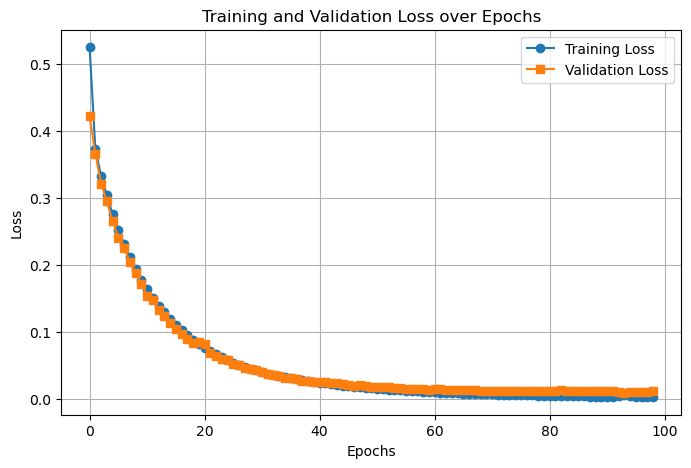

In [22]:
plot_losses(training_losses, validation_losses)

In [23]:
def evaluate_model(model, test_loader, device, threshold):
    model.eval()
    dice_scores = []
    f1_scores = []
    lesion_accuracies = []
    all_preds = []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold  # Binarize predictions
            all_preds.append(preds.cpu().numpy())
            for i in range(images.size(0)):
                true = masks[i].cpu().numpy().flatten()
                pred = preds[i].cpu().numpy().flatten()
                dice_scores.append(dice_score(true, pred))
                f1 = f1_score(true, pred, zero_division=1)
                f1_scores.append(f1)
                lesion_accuracies.append(lesion_wise_accuracy(masks[i].cpu().numpy(), preds[i].cpu().numpy()))
    return dice_scores, f1_scores, lesion_accuracies, np.concatenate(all_preds, axis=0)

In [24]:
train_dice_scores, f1_scores, lesion_accuracies, preds = evaluate_model(model_exp1, test_loader, DEVICE, threshold=0.5)
print(f"Mean Dice Score for U-Net: {np.mean(train_dice_scores):.4f}")
print(f"Mean F1 Score for U-Net: {np.mean(f1_scores):.4f}")
print(f"Mean Lesion-wise Accuracy for U-Net: {np.mean(lesion_accuracies):.4f}")

Mean Dice Score for U-Net: 0.7363
Mean F1 Score for U-Net: 0.7363
Mean Lesion-wise Accuracy for U-Net: 0.9050


In [27]:
unet_predicted_masks = preds.reshape(test_images.shape)
unet_predicted_masks.shape

(947, 128, 128)

In [ ]:
class plotSamples:
    def __init__(self, predicted_masks, test_images, test_masks):
        self.predicted_masks = predicted_masks
        self.test_images = test_images
        self.test_masks = test_masks

    def plot_best_worst(self, num_samples=2):
        dice_list = []
        for i in range(self.predicted_masks.shape[0]):
            if self.test_masks[i].sum() >= 100:  #I want to see only those masks which has at least 100 white pixels
                true = self.test_masks[i].flatten()
                pred = self.predicted_masks[i].flatten()
                d = dice_score(true, pred)
                dice_list.append((i, d))   

        # Sort by score
        dice_list = sorted(dice_list, key=lambda x: x[1])  # ascending
        worst_indices = [idx for idx, _ in dice_list[:num_samples]]
        best_indices = [idx for idx, _ in dice_list[-num_samples:]]

        selected_indices = best_indices + worst_indices

        # Plot
        plt.figure(figsize=(12, 4 * len(selected_indices)))

        for plot_i, idx in enumerate(selected_indices):
            row = plot_i

            # Ground Truth Mask
            plt.subplot(len(selected_indices), 3, row*3 + 1)
            plt.imshow(self.test_masks[idx], cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            # Predicted Mask
            plt.subplot(len(selected_indices), 3, row*3 + 2)
            plt.imshow(self.predicted_masks[idx], cmap='gray')
            if idx in best_indices:
                plt.title("Predicted (Best)")
            else:
                plt.title("Predicted (Worst)")
            plt.axis('off')

        plt.tight_layout()
        plt.show()


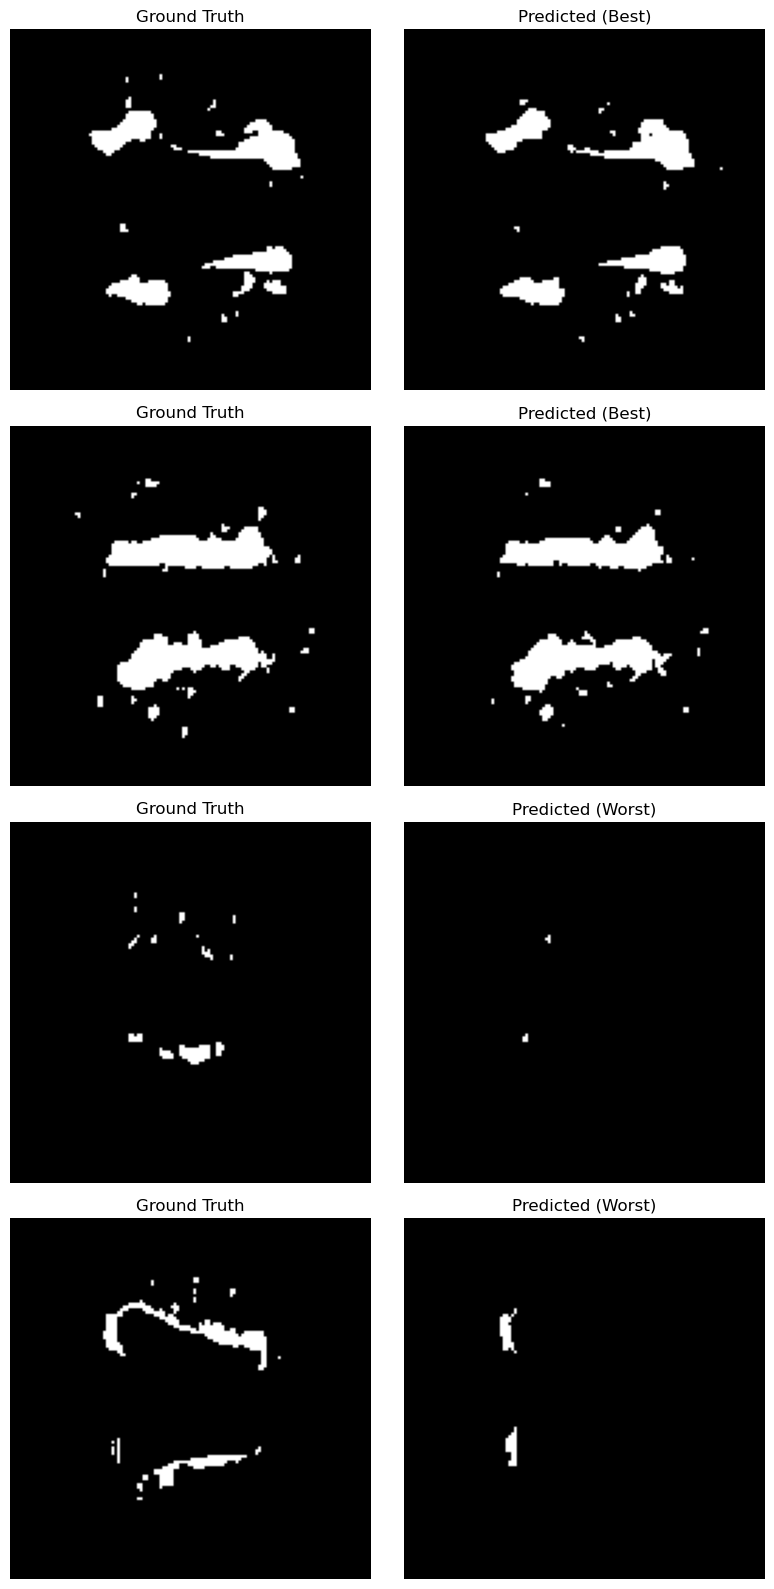

In [67]:
plotSamples(unet_predicted_masks, test_images, test_masks).plot_best_worst(num_samples=2)

### Experiment 2
#### Train the model using a combination of Dice loss and weighted Cross-Entropy loss

In [81]:
def dice_loss(preds, targets, threshold, smooth=1):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(2,3))
    total = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (total + smooth)
    loss = 1 - dice
    return loss.mean()

In [79]:
from sklearn.utils import class_weight
labels = training_masks.flatten()
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print(f"Class Weights: {class_weights}")
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"class weights dict: {class_weights_dict}")
pos_weight = class_weights[1] / class_weights[0]
pos_weight = pos_weight.to(DEVICE)
print(f"Positive class weight for Cross-Entropy Loss: {pos_weight}")

Class Weights: tensor([ 0.5028, 89.8312], device='cuda:0')
class weights dict: {0: tensor(0.5028, device='cuda:0'), 1: tensor(89.8312, device='cuda:0')}
Positive class weight for Cross-Entropy Loss: 178.662353515625


In [76]:
def combined_loss(preds, targets, class_weights, alpha):
    bce_loss = nn.BCEWithLogitsLoss(weight=class_weights)(preds, targets)
    dice_loss_val = dice_loss(preds, targets, threshold=0.5)
    return alpha*bce_loss + (1-alpha) * dice_loss_val

In [44]:
criterion = lambda preds, targets: combined_loss(preds, targets, pos_weight, 0.7)
model_exp2 = UNet(in_channels=1, num_classes=1)
optimizer = optim.Adam(model_exp2.parameters(), lr=0.0001, weight_decay=1e-4,amsgrad=True)
model_exp2 = model_exp2.to(DEVICE)
num_epochs = 100
patience_counter = 7

In [45]:
training_losses, validation_losses, train_dice_scores, valid_dice_scores = trainer_class(model_exp2, train_loader, test_loader, criterion, optimizer, num_epochs, device, patience_counter, scheduler=None)

Validation Epoch 1/100: 100%|██████████| 30/30 [00:01<00:00, 29.85it/s]


Epoch 1/100, Train Loss: 54.8146, Val Loss: 43.7171


Validation Epoch 2/100: 100%|██████████| 30/30 [00:01<00:00, 29.66it/s]


Epoch 2/100, Train Loss: 38.6476, Val Loss: 36.7753


Validation Epoch 3/100: 100%|██████████| 30/30 [00:01<00:00, 29.78it/s]


Epoch 3/100, Train Loss: 33.3531, Val Loss: 30.7940


Validation Epoch 4/100: 100%|██████████| 30/30 [00:01<00:00, 29.72it/s]


Epoch 4/100, Train Loss: 29.2543, Val Loss: 28.2729


Validation Epoch 5/100: 100%|██████████| 30/30 [00:01<00:00, 29.85it/s]


Epoch 5/100, Train Loss: 25.6808, Val Loss: 24.3218


Validation Epoch 6/100: 100%|██████████| 30/30 [00:01<00:00, 29.75it/s]


Epoch 6/100, Train Loss: 22.5819, Val Loss: 21.4968


Validation Epoch 7/100: 100%|██████████| 30/30 [00:01<00:00, 29.68it/s]


Epoch 7/100, Train Loss: 19.9259, Val Loss: 19.6240


Validation Epoch 8/100: 100%|██████████| 30/30 [00:01<00:00, 29.68it/s]


Epoch 8/100, Train Loss: 17.4601, Val Loss: 17.3830


Validation Epoch 9/100: 100%|██████████| 30/30 [00:01<00:00, 29.67it/s]


Epoch 9/100, Train Loss: 15.2585, Val Loss: 14.5666


Validation Epoch 10/100: 100%|██████████| 30/30 [00:01<00:00, 29.68it/s]


Epoch 10/100, Train Loss: 13.2707, Val Loss: 12.5337


Validation Epoch 11/100: 100%|██████████| 30/30 [00:01<00:00, 29.65it/s]


Epoch 11/100, Train Loss: 11.6044, Val Loss: 11.3560


Validation Epoch 12/100: 100%|██████████| 30/30 [00:01<00:00, 29.56it/s]


Epoch 12/100, Train Loss: 10.1004, Val Loss: 9.2533


Validation Epoch 13/100: 100%|██████████| 30/30 [00:01<00:00, 29.61it/s]


Epoch 13/100, Train Loss: 8.7127, Val Loss: 8.4273


Validation Epoch 14/100: 100%|██████████| 30/30 [00:01<00:00, 29.56it/s]


Epoch 14/100, Train Loss: 7.5127, Val Loss: 7.3685


Validation Epoch 15/100: 100%|██████████| 30/30 [00:01<00:00, 29.58it/s]


Epoch 15/100, Train Loss: 6.5681, Val Loss: 6.5796


Validation Epoch 16/100: 100%|██████████| 30/30 [00:01<00:00, 29.46it/s]


Epoch 16/100, Train Loss: 5.7711, Val Loss: 5.2809


Validation Epoch 17/100: 100%|██████████| 30/30 [00:01<00:00, 29.50it/s]


Epoch 17/100, Train Loss: 4.9982, Val Loss: 4.8878


Validation Epoch 18/100: 100%|██████████| 30/30 [00:01<00:00, 29.56it/s]


Epoch 18/100, Train Loss: 4.4402, Val Loss: 4.1987


Validation Epoch 19/100: 100%|██████████| 30/30 [00:01<00:00, 29.56it/s]


Epoch 19/100, Train Loss: 3.8100, Val Loss: 3.6712


Validation Epoch 20/100: 100%|██████████| 30/30 [00:01<00:00, 29.53it/s]


Epoch 20/100, Train Loss: 3.3546, Val Loss: 3.3717


Validation Epoch 21/100: 100%|██████████| 30/30 [00:01<00:00, 29.48it/s]


Epoch 21/100, Train Loss: 3.0560, Val Loss: 2.9013


Validation Epoch 22/100: 100%|██████████| 30/30 [00:01<00:00, 29.58it/s]


Epoch 22/100, Train Loss: 2.7142, Val Loss: 2.7469


Validation Epoch 23/100: 100%|██████████| 30/30 [00:01<00:00, 29.52it/s]


Epoch 23/100, Train Loss: 2.3837, Val Loss: 2.3461


Validation Epoch 24/100: 100%|██████████| 30/30 [00:01<00:00, 29.40it/s]


Epoch 24/100, Train Loss: 2.1740, Val Loss: 2.1217


Validation Epoch 25/100: 100%|██████████| 30/30 [00:01<00:00, 29.42it/s]


Epoch 25/100, Train Loss: 1.9424, Val Loss: 1.8288


Validation Epoch 26/100: 100%|██████████| 30/30 [00:01<00:00, 29.50it/s]


Epoch 26/100, Train Loss: 1.7261, Val Loss: 1.7311


Validation Epoch 27/100: 100%|██████████| 30/30 [00:01<00:00, 29.44it/s]


Epoch 27/100, Train Loss: 1.6024, Val Loss: 1.5553


Validation Epoch 28/100: 100%|██████████| 30/30 [00:01<00:00, 29.31it/s]


Epoch 28/100, Train Loss: 1.4719, Val Loss: 1.6697


Validation Epoch 29/100: 100%|██████████| 30/30 [00:01<00:00, 29.42it/s]


Epoch 29/100, Train Loss: 1.3694, Val Loss: 1.5171


Validation Epoch 30/100: 100%|██████████| 30/30 [00:01<00:00, 29.45it/s]


Epoch 30/100, Train Loss: 1.2600, Val Loss: 1.3947


Validation Epoch 31/100: 100%|██████████| 30/30 [00:01<00:00, 29.45it/s]


Epoch 31/100, Train Loss: 1.1839, Val Loss: 1.4303


Validation Epoch 32/100: 100%|██████████| 30/30 [00:01<00:00, 29.44it/s]


Epoch 32/100, Train Loss: 1.1306, Val Loss: 1.2581


Validation Epoch 33/100: 100%|██████████| 30/30 [00:01<00:00, 29.40it/s]


Epoch 33/100, Train Loss: 1.0469, Val Loss: 1.3324


Validation Epoch 34/100: 100%|██████████| 30/30 [00:01<00:00, 29.39it/s]


Epoch 34/100, Train Loss: 0.9750, Val Loss: 1.1523


Validation Epoch 35/100: 100%|██████████| 30/30 [00:01<00:00, 29.45it/s]


Epoch 35/100, Train Loss: 0.9296, Val Loss: 1.1090


Validation Epoch 36/100: 100%|██████████| 30/30 [00:01<00:00, 29.44it/s]


Epoch 36/100, Train Loss: 0.8708, Val Loss: 1.0520


Validation Epoch 37/100: 100%|██████████| 30/30 [00:01<00:00, 29.41it/s]


Epoch 37/100, Train Loss: 0.8284, Val Loss: 1.1068


Validation Epoch 38/100: 100%|██████████| 30/30 [00:01<00:00, 29.40it/s]


Epoch 38/100, Train Loss: 0.7818, Val Loss: 1.0643


Validation Epoch 39/100: 100%|██████████| 30/30 [00:01<00:00, 29.42it/s]


Epoch 39/100, Train Loss: 0.7558, Val Loss: 1.0610


Validation Epoch 40/100: 100%|██████████| 30/30 [00:01<00:00, 29.43it/s]


Epoch 40/100, Train Loss: 0.7357, Val Loss: 1.2029


Validation Epoch 41/100: 100%|██████████| 30/30 [00:01<00:00, 29.35it/s]


Epoch 41/100, Train Loss: 0.7027, Val Loss: 1.0009


Validation Epoch 42/100: 100%|██████████| 30/30 [00:01<00:00, 29.41it/s]


Epoch 42/100, Train Loss: 0.6905, Val Loss: 0.9890


Validation Epoch 43/100: 100%|██████████| 30/30 [00:01<00:00, 29.43it/s]


Epoch 43/100, Train Loss: 0.6599, Val Loss: 1.0413


Validation Epoch 44/100: 100%|██████████| 30/30 [00:01<00:00, 29.41it/s]


Epoch 44/100, Train Loss: 0.6318, Val Loss: 0.9911


Validation Epoch 45/100: 100%|██████████| 30/30 [00:01<00:00, 29.41it/s]


Epoch 45/100, Train Loss: 0.5927, Val Loss: 0.9670


Validation Epoch 46/100: 100%|██████████| 30/30 [00:01<00:00, 29.33it/s]


Epoch 46/100, Train Loss: 0.5790, Val Loss: 0.9883


Validation Epoch 47/100: 100%|██████████| 30/30 [00:01<00:00, 29.36it/s]


Epoch 47/100, Train Loss: 0.5558, Val Loss: 0.9879


Validation Epoch 48/100: 100%|██████████| 30/30 [00:01<00:00, 29.41it/s]


Epoch 48/100, Train Loss: 0.5306, Val Loss: 0.9414


Validation Epoch 49/100: 100%|██████████| 30/30 [00:01<00:00, 29.39it/s]


Epoch 49/100, Train Loss: 0.5137, Val Loss: 0.9538


Validation Epoch 50/100: 100%|██████████| 30/30 [00:01<00:00, 29.38it/s]


Epoch 50/100, Train Loss: 0.5220, Val Loss: 0.9675


Validation Epoch 51/100: 100%|██████████| 30/30 [00:01<00:00, 29.42it/s]


Epoch 51/100, Train Loss: 0.4877, Val Loss: 0.9501


Validation Epoch 52/100: 100%|██████████| 30/30 [00:01<00:00, 29.40it/s]


Epoch 52/100, Train Loss: 0.4537, Val Loss: 1.0188


Validation Epoch 53/100: 100%|██████████| 30/30 [00:01<00:00, 29.33it/s]


Epoch 53/100, Train Loss: 0.4480, Val Loss: 0.9630


Validation Epoch 54/100: 100%|██████████| 30/30 [00:01<00:00, 29.43it/s]


Epoch 54/100, Train Loss: 0.4188, Val Loss: 0.9974


Validation Epoch 55/100: 100%|██████████| 30/30 [00:01<00:00, 29.39it/s]

Epoch 55/100, Train Loss: 0.4119, Val Loss: 0.9960
Early stopping triggered


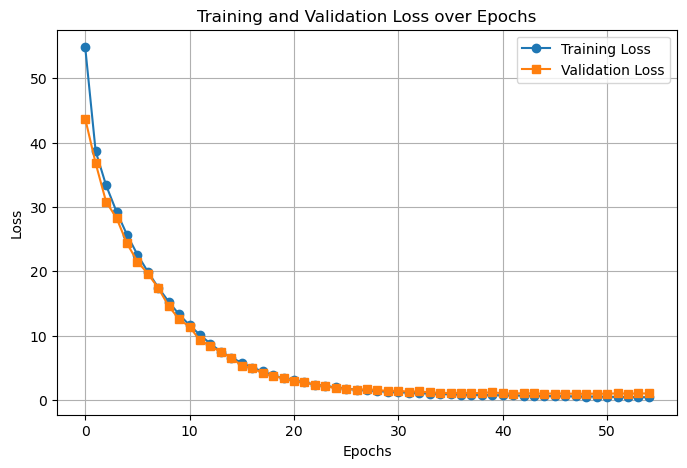

In [46]:
plot_losses(training_losses, validation_losses)

In [70]:
model_exp2 = UNet(in_channels=1, num_classes=1)
model_exp2.load_state_dict(torch.load("unet_model2.pth"))
model_exp2 = model_exp2.to(DEVICE)
train_dice_scores, f1_scores, lesion_accuracies, preds = evaluate_model(model_exp2, test_loader, DEVICE, threshold=0.47)
print(f"Mean Dice Score: {np.mean(train_dice_scores):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Lesion-wise Accuracy: {np.mean(lesion_accuracies):.4f}")


Mean Dice Score: 0.7796
Mean F1 Score: 0.7796
Mean Lesion-wise Accuracy: 0.9345


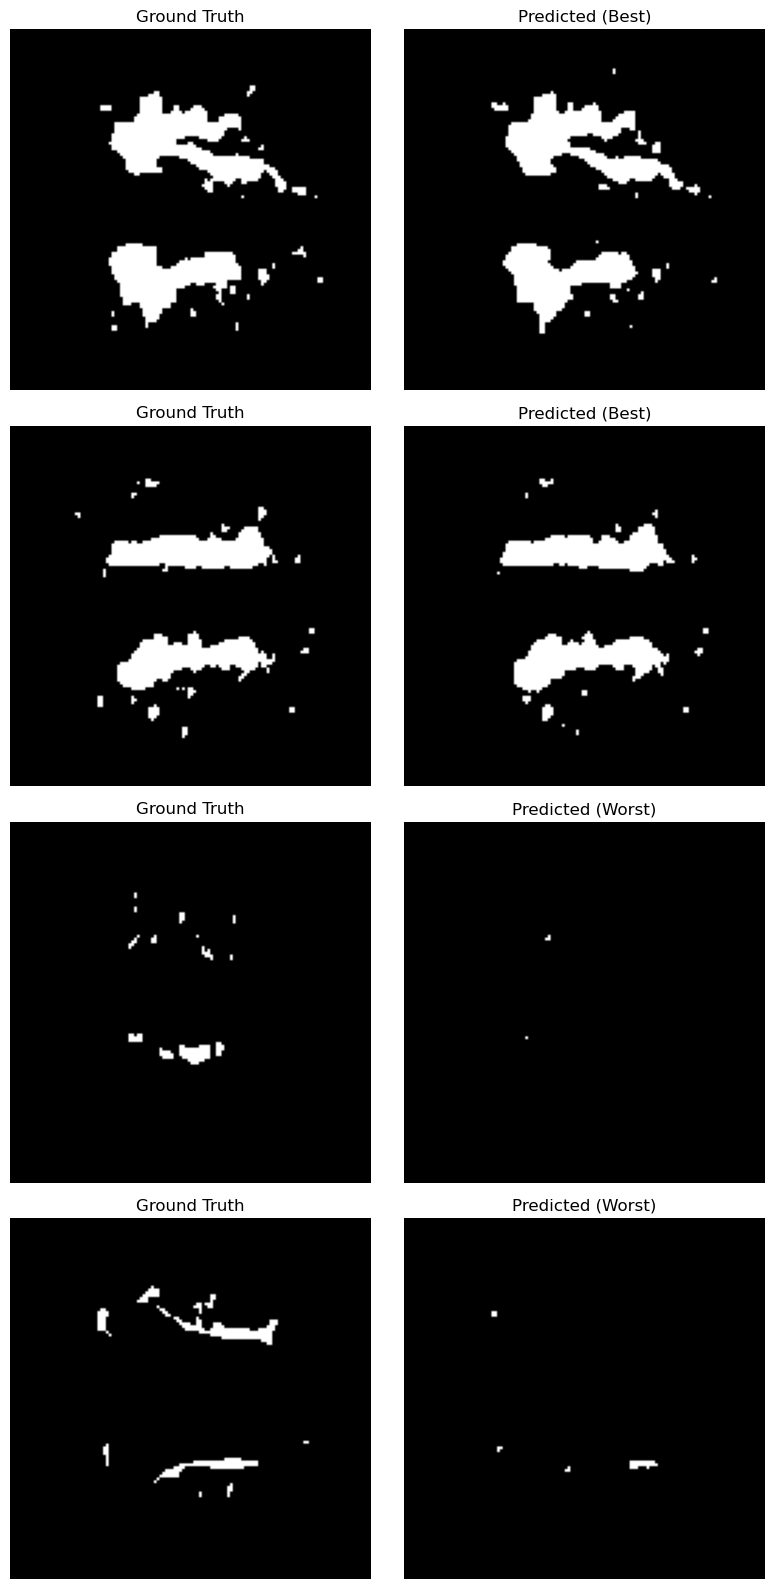

In [ ]:
unet_predicted_masks_exp2 = preds.reshape(test_images.shape)
plotSamples(unet_predicted_masks_exp2, test_images, test_masks).plot_best_worst(num_samples=2)

## Experiment 3
### Learning Rate Scheduler

In [54]:
model_exp3 = UNet(1,1)
model_exp3 = model_exp3.to(DEVICE)
optimizer = optim.Adam(model_exp3.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = lambda preds, targets: combined_loss(preds, targets, pos_weight, 0.5)
num_epochs = 75
patience_counter = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

In [55]:
training_losses, validation_losses, train_dice_scores, valid_dice_scores = trainer_class(model_exp3, train_loader, test_loader, criterion, optimizer, num_epochs, device, patience_counter, scheduler=scheduler)

Validation Epoch 1/75: 100%|██████████| 30/30 [00:01<00:00, 29.82it/s]


Epoch 1/75, Train Loss: 27.0932, Val Loss: 15.9953


Validation Epoch 2/75: 100%|██████████| 30/30 [00:01<00:00, 29.88it/s]


Epoch 2/75, Train Loss: 7.0278, Val Loss: 4.2923


Validation Epoch 3/75: 100%|██████████| 30/30 [00:01<00:00, 29.85it/s]


Epoch 3/75, Train Loss: 2.0849, Val Loss: 1.4805


Validation Epoch 4/75: 100%|██████████| 30/30 [00:01<00:00, 29.75it/s]


Epoch 4/75, Train Loss: 1.3602, Val Loss: 1.6646


Validation Epoch 5/75: 100%|██████████| 30/30 [00:01<00:00, 29.72it/s]


Epoch 5/75, Train Loss: 1.0599, Val Loss: 1.0313


Validation Epoch 6/75: 100%|██████████| 30/30 [00:01<00:00, 29.72it/s]


Epoch 6/75, Train Loss: 0.9719, Val Loss: 1.6006


Validation Epoch 7/75: 100%|██████████| 30/30 [00:01<00:00, 29.68it/s]


Epoch 7/75, Train Loss: 0.9150, Val Loss: 1.7584


Validation Epoch 8/75: 100%|██████████| 30/30 [00:01<00:00, 29.65it/s]


Epoch 8/75, Train Loss: 0.8220, Val Loss: 1.6435


Validation Epoch 9/75: 100%|██████████| 30/30 [00:01<00:00, 29.65it/s]


Epoch 9/75, Train Loss: 0.8409, Val Loss: 1.1359


Validation Epoch 10/75: 100%|██████████| 30/30 [00:01<00:00, 29.62it/s]


Epoch 10/75, Train Loss: 0.8152, Val Loss: 1.4350


Validation Epoch 11/75: 100%|██████████| 30/30 [00:01<00:00, 29.52it/s]


Epoch 11/75, Train Loss: 0.7492, Val Loss: 1.0494


Validation Epoch 12/75: 100%|██████████| 30/30 [00:01<00:00, 29.58it/s]


Epoch 12/75, Train Loss: 0.6291, Val Loss: 0.9158


Validation Epoch 13/75: 100%|██████████| 30/30 [00:01<00:00, 29.56it/s]


Epoch 13/75, Train Loss: 0.6130, Val Loss: 0.7191


Validation Epoch 14/75: 100%|██████████| 30/30 [00:01<00:00, 29.55it/s]


Epoch 14/75, Train Loss: 0.5955, Val Loss: 0.7398


Validation Epoch 15/75: 100%|██████████| 30/30 [00:01<00:00, 29.59it/s]


Epoch 15/75, Train Loss: 0.6088, Val Loss: 0.8222


Validation Epoch 16/75: 100%|██████████| 30/30 [00:01<00:00, 29.54it/s]


Epoch 16/75, Train Loss: 0.5866, Val Loss: 0.7262


Validation Epoch 17/75: 100%|██████████| 30/30 [00:01<00:00, 29.55it/s]


Epoch 17/75, Train Loss: 0.5877, Val Loss: 0.7016


Validation Epoch 18/75: 100%|██████████| 30/30 [00:01<00:00, 29.51it/s]


Epoch 18/75, Train Loss: 0.5607, Val Loss: 0.7747


Validation Epoch 19/75: 100%|██████████| 30/30 [00:01<00:00, 29.56it/s]


Epoch 19/75, Train Loss: 0.5603, Val Loss: 0.6729


Validation Epoch 20/75: 100%|██████████| 30/30 [00:01<00:00, 29.55it/s]


Epoch 20/75, Train Loss: 0.5441, Val Loss: 0.7697


Validation Epoch 21/75: 100%|██████████| 30/30 [00:01<00:00, 29.49it/s]


Epoch 21/75, Train Loss: 0.5492, Val Loss: 0.7999


Validation Epoch 22/75: 100%|██████████| 30/30 [00:01<00:00, 29.46it/s]


Epoch 22/75, Train Loss: 0.5420, Val Loss: 0.7731


Validation Epoch 23/75: 100%|██████████| 30/30 [00:01<00:00, 29.50it/s]


Epoch 23/75, Train Loss: 0.5458, Val Loss: 0.6937


Validation Epoch 24/75: 100%|██████████| 30/30 [00:01<00:00, 29.45it/s]


Epoch 24/75, Train Loss: 0.5374, Val Loss: 0.6651


Validation Epoch 25/75: 100%|██████████| 30/30 [00:01<00:00, 29.51it/s]


Epoch 25/75, Train Loss: 0.5345, Val Loss: 0.7210


Validation Epoch 26/75: 100%|██████████| 30/30 [00:01<00:00, 29.52it/s]


Epoch 26/75, Train Loss: 0.5274, Val Loss: 0.6969


Validation Epoch 27/75: 100%|██████████| 30/30 [00:01<00:00, 29.50it/s]


Epoch 27/75, Train Loss: 0.5217, Val Loss: 0.8617


Validation Epoch 28/75: 100%|██████████| 30/30 [00:01<00:00, 29.51it/s]


Epoch 28/75, Train Loss: 0.5222, Val Loss: 0.6591


Validation Epoch 29/75: 100%|██████████| 30/30 [00:01<00:00, 29.50it/s]


Epoch 29/75, Train Loss: 0.5361, Val Loss: 0.6741


Validation Epoch 30/75: 100%|██████████| 30/30 [00:01<00:00, 29.46it/s]


Epoch 30/75, Train Loss: 0.5176, Val Loss: 0.7810


Validation Epoch 31/75: 100%|██████████| 30/30 [00:01<00:00, 29.49it/s]


Epoch 31/75, Train Loss: 0.5189, Val Loss: 0.7114


Validation Epoch 32/75: 100%|██████████| 30/30 [00:01<00:00, 29.46it/s]


Epoch 32/75, Train Loss: 0.5331, Val Loss: 0.9754


Validation Epoch 33/75: 100%|██████████| 30/30 [00:01<00:00, 29.48it/s]


Epoch 33/75, Train Loss: 0.5051, Val Loss: 0.7337


Validation Epoch 34/75: 100%|██████████| 30/30 [00:01<00:00, 29.46it/s]


Epoch 34/75, Train Loss: 0.5076, Val Loss: 0.6589


Validation Epoch 35/75: 100%|██████████| 30/30 [00:01<00:00, 29.46it/s]


Epoch 35/75, Train Loss: 0.4974, Val Loss: 0.7371


Validation Epoch 36/75: 100%|██████████| 30/30 [00:01<00:00, 29.45it/s]


Epoch 36/75, Train Loss: 0.4903, Val Loss: 0.7348


Validation Epoch 37/75: 100%|██████████| 30/30 [00:01<00:00, 29.47it/s]


Epoch 37/75, Train Loss: 0.4792, Val Loss: 0.7170


Validation Epoch 38/75: 100%|██████████| 30/30 [00:01<00:00, 29.49it/s]


Epoch 38/75, Train Loss: 0.4897, Val Loss: 0.8518


Validation Epoch 39/75: 100%|██████████| 30/30 [00:01<00:00, 29.47it/s]


Epoch 39/75, Train Loss: 0.4994, Val Loss: 0.6587


Validation Epoch 40/75: 100%|██████████| 30/30 [00:01<00:00, 29.43it/s]


Epoch 40/75, Train Loss: 0.4802, Val Loss: 0.6525


Validation Epoch 41/75: 100%|██████████| 30/30 [00:01<00:00, 29.44it/s]


Epoch 41/75, Train Loss: 0.4707, Val Loss: 0.6441


Validation Epoch 42/75: 100%|██████████| 30/30 [00:01<00:00, 29.41it/s]


Epoch 42/75, Train Loss: 0.4745, Val Loss: 0.6808


Validation Epoch 43/75: 100%|██████████| 30/30 [00:01<00:00, 29.47it/s]


Epoch 43/75, Train Loss: 0.4743, Val Loss: 0.7059


Validation Epoch 44/75: 100%|██████████| 30/30 [00:01<00:00, 29.48it/s]


Epoch 44/75, Train Loss: 0.4619, Val Loss: 0.6382


Validation Epoch 45/75: 100%|██████████| 30/30 [00:01<00:00, 29.42it/s]


Epoch 45/75, Train Loss: 0.4678, Val Loss: 0.6596


Validation Epoch 46/75: 100%|██████████| 30/30 [00:01<00:00, 29.46it/s]


Epoch 46/75, Train Loss: 0.4612, Val Loss: 0.7304


Validation Epoch 47/75: 100%|██████████| 30/30 [00:01<00:00, 29.47it/s]


Epoch 47/75, Train Loss: 0.4605, Val Loss: 0.8291


Validation Epoch 48/75: 100%|██████████| 30/30 [00:01<00:00, 29.48it/s]


Epoch 48/75, Train Loss: 0.4528, Val Loss: 0.7643


Validation Epoch 49/75: 100%|██████████| 30/30 [00:01<00:00, 29.42it/s]


Epoch 49/75, Train Loss: 0.4495, Val Loss: 0.7537


Validation Epoch 50/75: 100%|██████████| 30/30 [00:01<00:00, 29.42it/s]


Epoch 50/75, Train Loss: 0.4524, Val Loss: 0.6621


Validation Epoch 51/75: 100%|██████████| 30/30 [00:01<00:00, 29.46it/s]


Epoch 51/75, Train Loss: 0.4379, Val Loss: 0.6627


Validation Epoch 52/75: 100%|██████████| 30/30 [00:01<00:00, 29.43it/s]


Epoch 52/75, Train Loss: 0.4301, Val Loss: 0.6391


Validation Epoch 53/75: 100%|██████████| 30/30 [00:01<00:00, 29.48it/s]


Epoch 53/75, Train Loss: 0.4177, Val Loss: 0.6516


Validation Epoch 54/75: 100%|██████████| 30/30 [00:01<00:00, 29.47it/s]

Epoch 54/75, Train Loss: 0.4165, Val Loss: 0.6386
Early stopping triggered


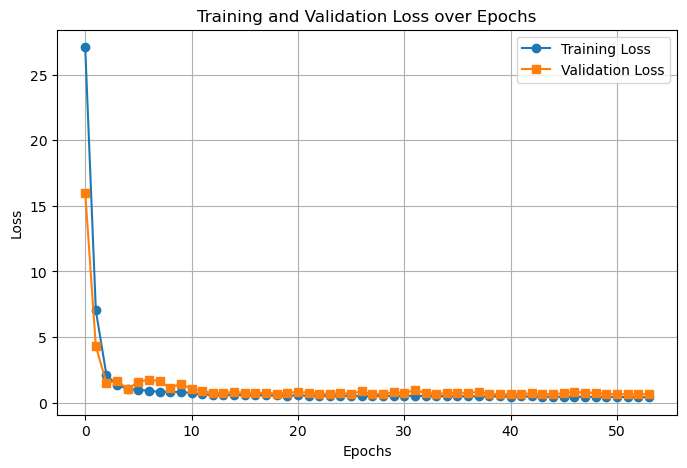

In [56]:
plot_losses(training_losses, validation_losses)

In [72]:
model_exp3 = UNet(in_channels=1, num_classes=1)
model_exp3.load_state_dict(torch.load("unet_model3.pth"))
model_exp3 = model_exp3.to(DEVICE)
train_dice_scores, f1_scores, lesion_accuracies, preds = evaluate_model(model_exp3, test_loader, DEVICE, threshold=0.47)
print(f"Mean Dice Score: {np.mean(train_dice_scores):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Lesion-wise Accuracy: {np.mean(lesion_accuracies):.4f}")

Mean Dice Score: 0.7814
Mean F1 Score: 0.7814
Mean Lesion-wise Accuracy: 0.9356


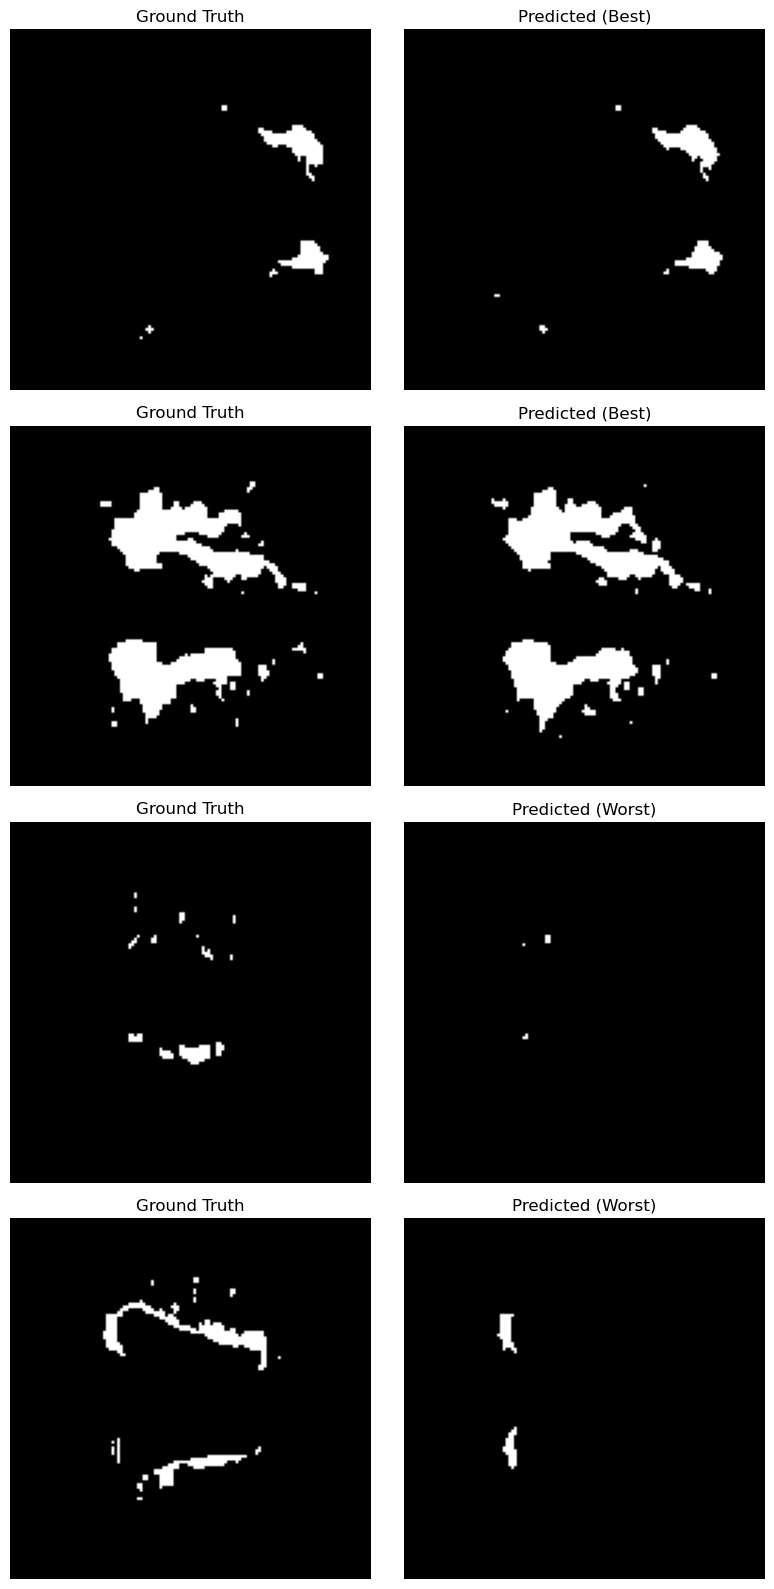

In [73]:
unet_predicted_masks_exp3 = preds.reshape(test_images.shape)
plotSamples(unet_predicted_masks_exp3, test_images, test_masks).plot_best_worst(num_samples=2)

## Experiment 4
### Varying depths of encoder

In [59]:
model_exp4 = UNet(1,1, depth=[True, True, False, False]) #Adding extra conv layers in first two encoder blocks
model_exp4 = model_exp4.to(DEVICE)
optimizer = optim.Adam(model_exp4.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = lambda preds, targets: combined_loss(preds, targets, pos_weight, 0.5)
num_epochs = 75
patience_counter = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

In [60]:
training_losses, validation_losses, train_dice_scores, valid_dice_scores = trainer_class(model_exp4, train_loader, test_loader, criterion, optimizer, num_epochs, device, patience_counter, scheduler=scheduler)

Validation Epoch 1/75: 100%|██████████| 30/30 [00:01<00:00, 24.26it/s]


Epoch 1/75, Train Loss: 40.6423, Val Loss: 31.2450


Validation Epoch 2/75: 100%|██████████| 30/30 [00:01<00:00, 24.31it/s]


Epoch 2/75, Train Loss: 25.8709, Val Loss: 25.5661


Validation Epoch 3/75: 100%|██████████| 30/30 [00:01<00:00, 24.26it/s]


Epoch 3/75, Train Loss: 22.8142, Val Loss: 23.6609


Validation Epoch 4/75: 100%|██████████| 30/30 [00:01<00:00, 24.19it/s]


Epoch 4/75, Train Loss: 19.9815, Val Loss: 19.1784


Validation Epoch 5/75: 100%|██████████| 30/30 [00:01<00:00, 24.11it/s]


Epoch 5/75, Train Loss: 17.8822, Val Loss: 16.8515


Validation Epoch 6/75: 100%|██████████| 30/30 [00:01<00:00, 24.15it/s]


Epoch 6/75, Train Loss: 15.8154, Val Loss: 14.9628


Validation Epoch 7/75: 100%|██████████| 30/30 [00:01<00:00, 24.11it/s]


Epoch 7/75, Train Loss: 14.0643, Val Loss: 13.6886


Validation Epoch 8/75: 100%|██████████| 30/30 [00:01<00:00, 24.11it/s]


Epoch 8/75, Train Loss: 12.4238, Val Loss: 11.6695


Validation Epoch 9/75: 100%|██████████| 30/30 [00:01<00:00, 24.06it/s]


Epoch 9/75, Train Loss: 11.0354, Val Loss: 10.5837


Validation Epoch 10/75: 100%|██████████| 30/30 [00:01<00:00, 24.02it/s]


Epoch 10/75, Train Loss: 9.6319, Val Loss: 8.6971


Validation Epoch 11/75: 100%|██████████| 30/30 [00:01<00:00, 23.18it/s]


Epoch 11/75, Train Loss: 8.4457, Val Loss: 8.5366


Validation Epoch 12/75: 100%|██████████| 30/30 [00:01<00:00, 23.36it/s]


Epoch 12/75, Train Loss: 7.4446, Val Loss: 8.3016


Validation Epoch 13/75: 100%|██████████| 30/30 [00:01<00:00, 24.02it/s]


Epoch 13/75, Train Loss: 6.5228, Val Loss: 6.2871


Validation Epoch 14/75: 100%|██████████| 30/30 [00:01<00:00, 24.05it/s]


Epoch 14/75, Train Loss: 5.6892, Val Loss: 5.3277


Validation Epoch 15/75: 100%|██████████| 30/30 [00:01<00:00, 23.99it/s]


Epoch 15/75, Train Loss: 4.9301, Val Loss: 4.9929


Validation Epoch 16/75: 100%|██████████| 30/30 [00:01<00:00, 24.00it/s]


Epoch 16/75, Train Loss: 4.2917, Val Loss: 4.3237


Validation Epoch 17/75: 100%|██████████| 30/30 [00:01<00:00, 23.98it/s]


Epoch 17/75, Train Loss: 3.7195, Val Loss: 3.4658


Validation Epoch 18/75: 100%|██████████| 30/30 [00:01<00:00, 23.97it/s]


Epoch 18/75, Train Loss: 3.3020, Val Loss: 3.0171


Validation Epoch 19/75: 100%|██████████| 30/30 [00:01<00:00, 23.96it/s]


Epoch 19/75, Train Loss: 2.8767, Val Loss: 2.7048


Validation Epoch 20/75: 100%|██████████| 30/30 [00:01<00:00, 23.93it/s]


Epoch 20/75, Train Loss: 2.5747, Val Loss: 2.5033


Validation Epoch 21/75: 100%|██████████| 30/30 [00:01<00:00, 23.97it/s]


Epoch 21/75, Train Loss: 2.2174, Val Loss: 2.1156


Validation Epoch 22/75: 100%|██████████| 30/30 [00:01<00:00, 23.96it/s]


Epoch 22/75, Train Loss: 1.9726, Val Loss: 2.0616


Validation Epoch 23/75: 100%|██████████| 30/30 [00:01<00:00, 23.95it/s]


Epoch 23/75, Train Loss: 1.7524, Val Loss: 1.8803


Validation Epoch 24/75: 100%|██████████| 30/30 [00:01<00:00, 23.96it/s]


Epoch 24/75, Train Loss: 1.5643, Val Loss: 1.5777


Validation Epoch 25/75: 100%|██████████| 30/30 [00:01<00:00, 23.90it/s]


Epoch 25/75, Train Loss: 1.4102, Val Loss: 1.4350


Validation Epoch 26/75: 100%|██████████| 30/30 [00:01<00:00, 23.90it/s]


Epoch 26/75, Train Loss: 1.2585, Val Loss: 1.3163


Validation Epoch 27/75: 100%|██████████| 30/30 [00:01<00:00, 23.90it/s]


Epoch 27/75, Train Loss: 1.1576, Val Loss: 1.2647


Validation Epoch 28/75: 100%|██████████| 30/30 [00:01<00:00, 23.89it/s]


Epoch 28/75, Train Loss: 1.0448, Val Loss: 1.1131


Validation Epoch 29/75: 100%|██████████| 30/30 [00:01<00:00, 23.90it/s]


Epoch 29/75, Train Loss: 0.9740, Val Loss: 1.1336


Validation Epoch 30/75: 100%|██████████| 30/30 [00:01<00:00, 23.92it/s]


Epoch 30/75, Train Loss: 0.8868, Val Loss: 1.0786


Validation Epoch 31/75: 100%|██████████| 30/30 [00:01<00:00, 23.93it/s]


Epoch 31/75, Train Loss: 0.8426, Val Loss: 1.0454


Validation Epoch 32/75: 100%|██████████| 30/30 [00:01<00:00, 23.95it/s]


Epoch 32/75, Train Loss: 0.7647, Val Loss: 0.9430


Validation Epoch 33/75: 100%|██████████| 30/30 [00:01<00:00, 23.95it/s]


Epoch 33/75, Train Loss: 0.7128, Val Loss: 0.8935


Validation Epoch 34/75: 100%|██████████| 30/30 [00:01<00:00, 23.95it/s]


Epoch 34/75, Train Loss: 0.6839, Val Loss: 0.8654


Validation Epoch 35/75: 100%|██████████| 30/30 [00:01<00:00, 23.92it/s]


Epoch 35/75, Train Loss: 0.6295, Val Loss: 0.8814


Validation Epoch 36/75: 100%|██████████| 30/30 [00:01<00:00, 23.95it/s]


Epoch 36/75, Train Loss: 0.6056, Val Loss: 0.7958


Validation Epoch 37/75: 100%|██████████| 30/30 [00:01<00:00, 23.96it/s]


Epoch 37/75, Train Loss: 0.5653, Val Loss: 0.8312


Validation Epoch 38/75: 100%|██████████| 30/30 [00:01<00:00, 23.89it/s]


Epoch 38/75, Train Loss: 0.5452, Val Loss: 0.8156


Validation Epoch 39/75: 100%|██████████| 30/30 [00:01<00:00, 23.95it/s]


Epoch 39/75, Train Loss: 0.5149, Val Loss: 0.7808


Validation Epoch 40/75: 100%|██████████| 30/30 [00:01<00:00, 23.91it/s]


Epoch 40/75, Train Loss: 0.4839, Val Loss: 0.8574


Validation Epoch 41/75: 100%|██████████| 30/30 [00:01<00:00, 23.94it/s]


Epoch 41/75, Train Loss: 0.4923, Val Loss: 0.9635


Validation Epoch 42/75: 100%|██████████| 30/30 [00:01<00:00, 23.95it/s]


Epoch 42/75, Train Loss: 0.4562, Val Loss: 0.9073


Validation Epoch 43/75: 100%|██████████| 30/30 [00:01<00:00, 23.95it/s]


Epoch 43/75, Train Loss: 0.4351, Val Loss: 0.7721


Validation Epoch 44/75: 100%|██████████| 30/30 [00:01<00:00, 23.94it/s]


Epoch 44/75, Train Loss: 0.4078, Val Loss: 0.7818


Validation Epoch 45/75: 100%|██████████| 30/30 [00:01<00:00, 23.90it/s]


Epoch 45/75, Train Loss: 0.3895, Val Loss: 0.7904


Validation Epoch 46/75: 100%|██████████| 30/30 [00:01<00:00, 23.96it/s]


Epoch 46/75, Train Loss: 0.3649, Val Loss: 0.8406


Validation Epoch 47/75: 100%|██████████| 30/30 [00:01<00:00, 23.94it/s]


Epoch 47/75, Train Loss: 0.3497, Val Loss: 0.7874


Validation Epoch 48/75: 100%|██████████| 30/30 [00:01<00:00, 23.92it/s]


Epoch 48/75, Train Loss: 0.3363, Val Loss: 0.8061


Validation Epoch 49/75: 100%|██████████| 30/30 [00:01<00:00, 23.92it/s]


Epoch 49/75, Train Loss: 0.3221, Val Loss: 0.8029


Validation Epoch 50/75: 100%|██████████| 30/30 [00:01<00:00, 23.90it/s]


Epoch 50/75, Train Loss: 0.2665, Val Loss: 0.7897


Validation Epoch 51/75: 100%|██████████| 30/30 [00:01<00:00, 23.93it/s]


Epoch 51/75, Train Loss: 0.2501, Val Loss: 0.8099


Validation Epoch 52/75: 100%|██████████| 30/30 [00:01<00:00, 23.93it/s]


Epoch 52/75, Train Loss: 0.2423, Val Loss: 0.8484


Validation Epoch 53/75: 100%|██████████| 30/30 [00:01<00:00, 23.92it/s]

Epoch 53/75, Train Loss: 0.2413, Val Loss: 0.8303
Early stopping triggered


In [61]:
train_dice_scores, f1_scores, lesion_accuracies, preds = evaluate_model(model_exp4, test_loader, device, threshold=0.47)
print(f"Mean Dice Score: {np.mean(train_dice_scores):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Lesion-wise Accuracy: {np.mean(lesion_accuracies):.4f}")

Mean Dice Score: 0.7796
Mean F1 Score: 0.7796
Mean Lesion-wise Accuracy: 0.9335


In [82]:
#Adding one extra conv layer in the encoder at a time
depths = [[False, False, True, False]]
for depth in depths:
    model = UNet(1,1, depth=depth)
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = lambda preds, targets: combined_loss(preds, targets, pos_weight, 0.5)
    num_epochs = 75
    patience_counter = 10
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

    training_losses, validation_losses, train_dice_scores, valid_dice_scores = trainer_class(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, patience_counter,depth_added=True, scheduler=scheduler)

Validation Epoch 68/75: 100%|██████████| 30/30 [00:01<00:00, 27.50it/s]

Early stopping triggered


In [97]:
train_dice_scores, f1_scores, lesion_accuracies, preds = evaluate_model(model, test_loader, device, threshold=0.47)
print(f"Depth {depth} Mean Dice Score: {np.mean(train_dice_scores):.4f}, Mean F1 Score: {np.mean(f1_scores):.4f}, Mean Lesion-wise Accuracy: {np.mean(lesion_accuracies):.4f}")

Depth [False, False, True, False] Mean Dice Score: 0.7873, Mean F1 Score: 0.7873, Mean Lesion-wise Accuracy: 0.9388


In [93]:
torch.save(model.state_dict(), "unet_model_depth_experiment.pth")

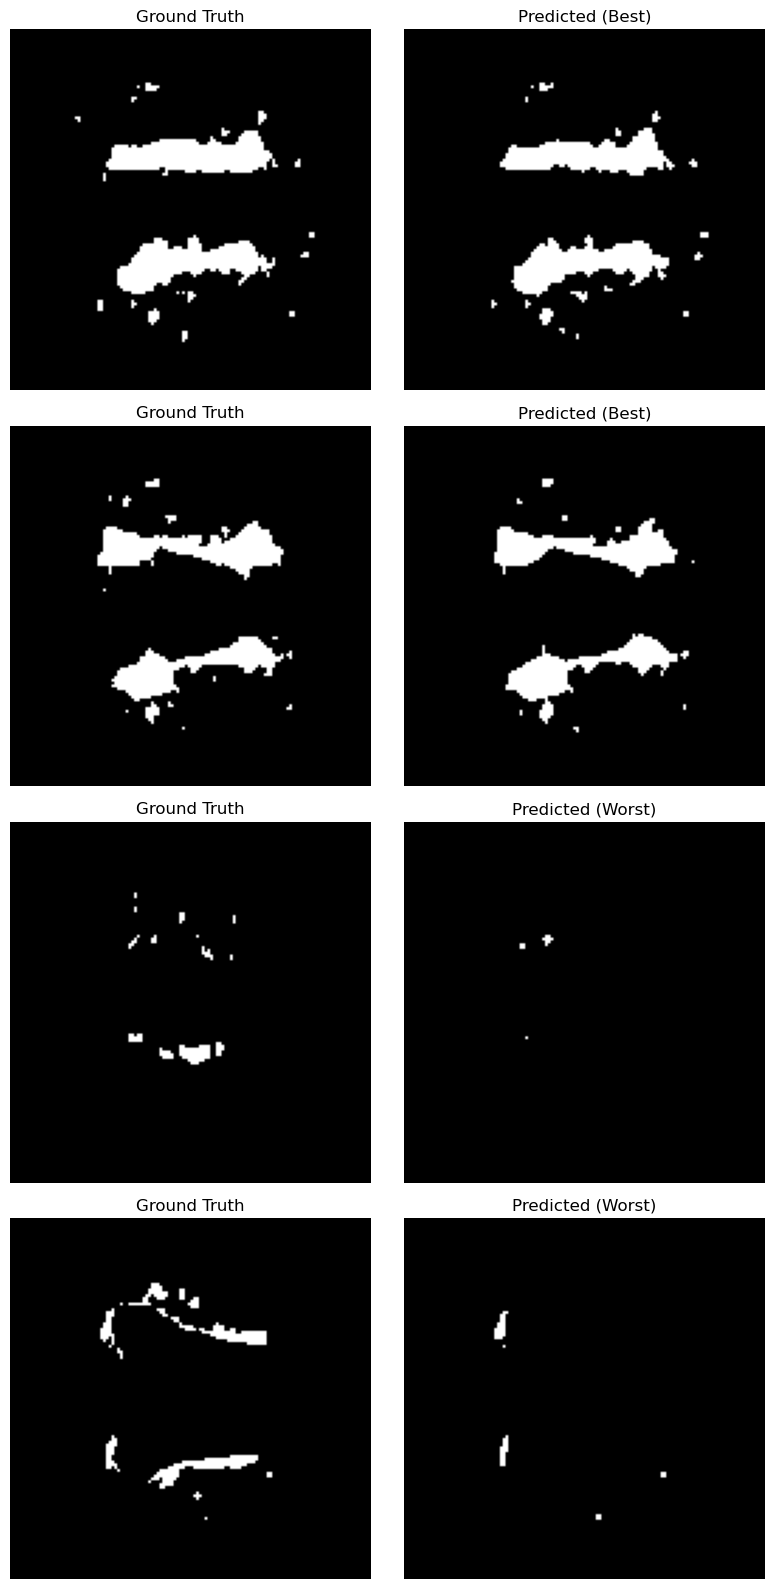

In [94]:
predicted_masks_depth_exp = preds.reshape(test_images.shape)
plotSamples(predicted_masks_depth_exp, test_images, test_masks).plot_best_worst(num_samples=2)

In [63]:
depths = [[True, True, True, False],
          [True, True, True, True]]
for depth in depths:
    model = UNet(1,1, depth=depth)
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = lambda preds, targets: combined_loss(preds, targets, pos_weight, 0.5)
    num_epochs = 75
    patience_counter = 10
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

    training_losses, validation_losses, train_dice_scores, valid_dice_scores = trainer_class(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, patience_counter, scheduler=scheduler)

    train_dice_scores, f1_scores, lesion_accuracies, preds = evaluate_model(model, test_loader, device, threshold=0.47)
    print(f"Depth {depth} -> Mean Dice Score: {np.mean(train_dice_scores):.4f}, Mean F1 Score: {np.mean(f1_scores):.4f}, Mean Lesion-wise Accuracy: {np.mean(lesion_accuracies):.4f}")

Validation Epoch 1/75: 100%|██████████| 30/30 [00:01<00:00, 22.80it/s]


Epoch 1/75, Train Loss: 43.4970, Val Loss: 33.8254


Validation Epoch 2/75: 100%|██████████| 30/30 [00:01<00:00, 22.77it/s]


Epoch 2/75, Train Loss: 29.0019, Val Loss: 28.4260


Validation Epoch 3/75: 100%|██████████| 30/30 [00:01<00:00, 22.81it/s]


Epoch 3/75, Train Loss: 25.4226, Val Loss: 24.8182


Validation Epoch 4/75: 100%|██████████| 30/30 [00:01<00:00, 22.79it/s]


Epoch 4/75, Train Loss: 22.5272, Val Loss: 21.4008


Validation Epoch 5/75: 100%|██████████| 30/30 [00:01<00:00, 22.74it/s]


Epoch 5/75, Train Loss: 19.8629, Val Loss: 18.6976


Validation Epoch 6/75: 100%|██████████| 30/30 [00:01<00:00, 22.76it/s]


Epoch 6/75, Train Loss: 17.6623, Val Loss: 16.6477


Validation Epoch 7/75: 100%|██████████| 30/30 [00:01<00:00, 22.78it/s]


Epoch 7/75, Train Loss: 15.4879, Val Loss: 14.8006


Validation Epoch 8/75: 100%|██████████| 30/30 [00:01<00:00, 22.78it/s]


Epoch 8/75, Train Loss: 13.6995, Val Loss: 12.6119


Validation Epoch 9/75: 100%|██████████| 30/30 [00:01<00:00, 22.80it/s]


Epoch 9/75, Train Loss: 12.0085, Val Loss: 11.9215


Validation Epoch 10/75: 100%|██████████| 30/30 [00:01<00:00, 22.80it/s]


Epoch 10/75, Train Loss: 10.5418, Val Loss: 10.4953


Validation Epoch 11/75: 100%|██████████| 30/30 [00:01<00:00, 22.80it/s]


Epoch 11/75, Train Loss: 9.1613, Val Loss: 8.9231


Validation Epoch 12/75: 100%|██████████| 30/30 [00:01<00:00, 22.75it/s]


Epoch 12/75, Train Loss: 8.0262, Val Loss: 7.6821


Validation Epoch 13/75: 100%|██████████| 30/30 [00:01<00:00, 22.80it/s]


Epoch 13/75, Train Loss: 7.0267, Val Loss: 7.3463


Validation Epoch 14/75: 100%|██████████| 30/30 [00:01<00:00, 22.78it/s]


Epoch 14/75, Train Loss: 6.1073, Val Loss: 5.1681


Validation Epoch 15/75: 100%|██████████| 30/30 [00:01<00:00, 22.79it/s]


Epoch 15/75, Train Loss: 5.3237, Val Loss: 4.6860


Validation Epoch 16/75: 100%|██████████| 30/30 [00:01<00:00, 22.78it/s]


Epoch 16/75, Train Loss: 4.6290, Val Loss: 3.9910


Validation Epoch 17/75: 100%|██████████| 30/30 [00:01<00:00, 22.76it/s]


Epoch 17/75, Train Loss: 4.0536, Val Loss: 3.9414


Validation Epoch 18/75: 100%|██████████| 30/30 [00:01<00:00, 22.79it/s]


Epoch 18/75, Train Loss: 3.5427, Val Loss: 3.0088


Validation Epoch 19/75: 100%|██████████| 30/30 [00:01<00:00, 22.77it/s]


Epoch 19/75, Train Loss: 3.0320, Val Loss: 3.0317


Validation Epoch 20/75: 100%|██████████| 30/30 [00:01<00:00, 22.79it/s]


Epoch 20/75, Train Loss: 2.6723, Val Loss: 2.6975


Validation Epoch 21/75: 100%|██████████| 30/30 [00:01<00:00, 22.74it/s]


Epoch 21/75, Train Loss: 2.3699, Val Loss: 2.7332


Validation Epoch 22/75: 100%|██████████| 30/30 [00:01<00:00, 22.61it/s]


Epoch 22/75, Train Loss: 2.0867, Val Loss: 2.7860


Validation Epoch 23/75: 100%|██████████| 30/30 [00:01<00:00, 22.65it/s]


Epoch 23/75, Train Loss: 1.8577, Val Loss: 1.7149


Validation Epoch 24/75: 100%|██████████| 30/30 [00:01<00:00, 22.57it/s]


Epoch 24/75, Train Loss: 1.6128, Val Loss: 1.6393


Validation Epoch 25/75: 100%|██████████| 30/30 [00:01<00:00, 22.67it/s]


Epoch 25/75, Train Loss: 1.4254, Val Loss: 1.5193


Validation Epoch 26/75: 100%|██████████| 30/30 [00:01<00:00, 22.71it/s]


Epoch 26/75, Train Loss: 1.2849, Val Loss: 1.5728


Validation Epoch 27/75: 100%|██████████| 30/30 [00:01<00:00, 22.71it/s]


Epoch 27/75, Train Loss: 1.1915, Val Loss: 1.1945


Validation Epoch 28/75: 100%|██████████| 30/30 [00:01<00:00, 22.74it/s]


Epoch 28/75, Train Loss: 1.0657, Val Loss: 1.1350


Validation Epoch 29/75: 100%|██████████| 30/30 [00:01<00:00, 22.73it/s]


Epoch 29/75, Train Loss: 0.9839, Val Loss: 1.1794


Validation Epoch 30/75: 100%|██████████| 30/30 [00:01<00:00, 22.72it/s]


Epoch 30/75, Train Loss: 0.8809, Val Loss: 1.0328


Validation Epoch 31/75: 100%|██████████| 30/30 [00:01<00:00, 22.73it/s]


Epoch 31/75, Train Loss: 0.8217, Val Loss: 0.9572


Validation Epoch 32/75: 100%|██████████| 30/30 [00:01<00:00, 22.72it/s]


Epoch 32/75, Train Loss: 0.7586, Val Loss: 0.9406


Validation Epoch 33/75: 100%|██████████| 30/30 [00:01<00:00, 22.75it/s]


Epoch 33/75, Train Loss: 0.7274, Val Loss: 0.9690


Validation Epoch 34/75: 100%|██████████| 30/30 [00:01<00:00, 22.72it/s]


Epoch 34/75, Train Loss: 0.6696, Val Loss: 0.8517


Validation Epoch 35/75: 100%|██████████| 30/30 [00:01<00:00, 22.78it/s]


Epoch 35/75, Train Loss: 0.6442, Val Loss: 0.8392


Validation Epoch 36/75: 100%|██████████| 30/30 [00:01<00:00, 22.79it/s]


Epoch 36/75, Train Loss: 0.6058, Val Loss: 0.8410


Validation Epoch 37/75: 100%|██████████| 30/30 [00:01<00:00, 22.77it/s]


Epoch 37/75, Train Loss: 0.5727, Val Loss: 0.8333


Validation Epoch 38/75: 100%|██████████| 30/30 [00:01<00:00, 22.78it/s]


Epoch 38/75, Train Loss: 0.5457, Val Loss: 0.8126


Validation Epoch 39/75: 100%|██████████| 30/30 [00:01<00:00, 22.73it/s]


Epoch 39/75, Train Loss: 0.5182, Val Loss: 0.7790


Validation Epoch 40/75: 100%|██████████| 30/30 [00:01<00:00, 22.75it/s]


Epoch 40/75, Train Loss: 0.4980, Val Loss: 0.7691


Validation Epoch 41/75: 100%|██████████| 30/30 [00:01<00:00, 22.75it/s]


Epoch 41/75, Train Loss: 0.4727, Val Loss: 0.8020


Validation Epoch 42/75: 100%|██████████| 30/30 [00:01<00:00, 22.79it/s]


Epoch 42/75, Train Loss: 0.4616, Val Loss: 0.7509


Validation Epoch 43/75: 100%|██████████| 30/30 [00:01<00:00, 22.76it/s]


Epoch 43/75, Train Loss: 0.4331, Val Loss: 0.7969


Validation Epoch 44/75: 100%|██████████| 30/30 [00:01<00:00, 22.78it/s]


Epoch 44/75, Train Loss: 0.4066, Val Loss: 0.7944


Validation Epoch 45/75: 100%|██████████| 30/30 [00:01<00:00, 22.78it/s]


Epoch 45/75, Train Loss: 0.4036, Val Loss: 0.9296


Validation Epoch 46/75: 100%|██████████| 30/30 [00:01<00:00, 22.70it/s]


Epoch 46/75, Train Loss: 0.3757, Val Loss: 0.7408


Validation Epoch 47/75: 100%|██████████| 30/30 [00:01<00:00, 22.72it/s]


Epoch 47/75, Train Loss: 0.3607, Val Loss: 0.7754


Validation Epoch 48/75: 100%|██████████| 30/30 [00:01<00:00, 22.68it/s]


Epoch 48/75, Train Loss: 0.3512, Val Loss: 0.7721


Validation Epoch 49/75: 100%|██████████| 30/30 [00:01<00:00, 22.66it/s]


Epoch 49/75, Train Loss: 0.3226, Val Loss: 0.7799


Validation Epoch 50/75: 100%|██████████| 30/30 [00:01<00:00, 22.66it/s]


Epoch 50/75, Train Loss: 0.3074, Val Loss: 0.7708


Validation Epoch 51/75: 100%|██████████| 30/30 [00:01<00:00, 22.66it/s]


Epoch 51/75, Train Loss: 0.3021, Val Loss: 0.8058


Validation Epoch 52/75: 100%|██████████| 30/30 [00:01<00:00, 22.69it/s]


Epoch 52/75, Train Loss: 0.2832, Val Loss: 0.7843


Validation Epoch 53/75: 100%|██████████| 30/30 [00:01<00:00, 22.66it/s]


Epoch 53/75, Train Loss: 0.2366, Val Loss: 0.8148


Validation Epoch 54/75: 100%|██████████| 30/30 [00:01<00:00, 21.84it/s]


Epoch 54/75, Train Loss: 0.2208, Val Loss: 0.8187


Validation Epoch 55/75: 100%|██████████| 30/30 [00:01<00:00, 22.75it/s]


Epoch 55/75, Train Loss: 0.2104, Val Loss: 0.8411


Validation Epoch 56/75: 100%|██████████| 30/30 [00:01<00:00, 22.71it/s]


Epoch 56/75, Train Loss: 0.2069, Val Loss: 0.8518
Early stopping triggered
Depth [True, True, True, False] -> Mean Dice Score: 0.7817, Mean F1 Score: 0.7817, Mean Lesion-wise Accuracy: 0.9419


Validation Epoch 1/75: 100%|██████████| 30/30 [00:01<00:00, 21.76it/s]


Epoch 1/75, Train Loss: 44.9780, Val Loss: 35.9468


Validation Epoch 2/75: 100%|██████████| 30/30 [00:01<00:00, 21.73it/s]


Epoch 2/75, Train Loss: 29.8797, Val Loss: 29.4991


Validation Epoch 3/75: 100%|██████████| 30/30 [00:01<00:00, 21.74it/s]


Epoch 3/75, Train Loss: 26.3148, Val Loss: 25.9763


Validation Epoch 4/75: 100%|██████████| 30/30 [00:01<00:00, 21.74it/s]


Epoch 4/75, Train Loss: 23.2924, Val Loss: 22.5956


Validation Epoch 5/75: 100%|██████████| 30/30 [00:01<00:00, 21.72it/s]


Epoch 5/75, Train Loss: 20.5389, Val Loss: 18.9053


Validation Epoch 6/75: 100%|██████████| 30/30 [00:01<00:00, 21.72it/s]


Epoch 6/75, Train Loss: 18.3185, Val Loss: 17.2464


Validation Epoch 7/75: 100%|██████████| 30/30 [00:01<00:00, 21.72it/s]


Epoch 7/75, Train Loss: 16.2285, Val Loss: 15.7361


Validation Epoch 8/75: 100%|██████████| 30/30 [00:01<00:00, 21.67it/s]


Epoch 8/75, Train Loss: 14.3924, Val Loss: 13.2641


Validation Epoch 9/75: 100%|██████████| 30/30 [00:01<00:00, 21.67it/s]


Epoch 9/75, Train Loss: 12.7692, Val Loss: 11.3469


Validation Epoch 10/75: 100%|██████████| 30/30 [00:01<00:00, 21.75it/s]


Epoch 10/75, Train Loss: 11.2235, Val Loss: 10.4129


Validation Epoch 11/75: 100%|██████████| 30/30 [00:01<00:00, 21.70it/s]


Epoch 11/75, Train Loss: 9.9003, Val Loss: 9.5128


Validation Epoch 12/75: 100%|██████████| 30/30 [00:01<00:00, 21.61it/s]


Epoch 12/75, Train Loss: 8.7387, Val Loss: 9.1206


Validation Epoch 13/75: 100%|██████████| 30/30 [00:01<00:00, 21.66it/s]


Epoch 13/75, Train Loss: 7.6684, Val Loss: 6.9921


Validation Epoch 14/75: 100%|██████████| 30/30 [00:01<00:00, 21.67it/s]


Epoch 14/75, Train Loss: 6.6286, Val Loss: 6.0780


Validation Epoch 15/75: 100%|██████████| 30/30 [00:01<00:00, 21.68it/s]


Epoch 15/75, Train Loss: 5.9380, Val Loss: 5.4766


Validation Epoch 16/75: 100%|██████████| 30/30 [00:01<00:00, 21.63it/s]


Epoch 16/75, Train Loss: 5.1813, Val Loss: 4.8210


Validation Epoch 17/75: 100%|██████████| 30/30 [00:01<00:00, 21.65it/s]


Epoch 17/75, Train Loss: 4.5114, Val Loss: 4.1661


Validation Epoch 18/75: 100%|██████████| 30/30 [00:01<00:00, 21.68it/s]


Epoch 18/75, Train Loss: 3.9860, Val Loss: 3.7571


Validation Epoch 19/75: 100%|██████████| 30/30 [00:01<00:00, 21.72it/s]


Epoch 19/75, Train Loss: 3.4913, Val Loss: 3.2988


Validation Epoch 20/75: 100%|██████████| 30/30 [00:01<00:00, 21.70it/s]


Epoch 20/75, Train Loss: 3.0847, Val Loss: 2.9628


Validation Epoch 21/75: 100%|██████████| 30/30 [00:01<00:00, 21.71it/s]


Epoch 21/75, Train Loss: 2.6889, Val Loss: 2.6204


Validation Epoch 22/75: 100%|██████████| 30/30 [00:01<00:00, 21.77it/s]


Epoch 22/75, Train Loss: 2.4157, Val Loss: 2.4893


Validation Epoch 23/75: 100%|██████████| 30/30 [00:01<00:00, 21.74it/s]


Epoch 23/75, Train Loss: 2.1568, Val Loss: 2.1941


Validation Epoch 24/75: 100%|██████████| 30/30 [00:01<00:00, 21.79it/s]


Epoch 24/75, Train Loss: 1.9119, Val Loss: 2.0736


Validation Epoch 25/75: 100%|██████████| 30/30 [00:01<00:00, 21.79it/s]


Epoch 25/75, Train Loss: 1.7372, Val Loss: 1.8258


Validation Epoch 26/75: 100%|██████████| 30/30 [00:01<00:00, 21.70it/s]


Epoch 26/75, Train Loss: 1.5427, Val Loss: 1.7182


Validation Epoch 27/75: 100%|██████████| 30/30 [00:01<00:00, 21.69it/s]


Epoch 27/75, Train Loss: 1.3703, Val Loss: 1.4745


Validation Epoch 28/75: 100%|██████████| 30/30 [00:01<00:00, 21.78it/s]


Epoch 28/75, Train Loss: 1.2552, Val Loss: 1.3406


Validation Epoch 29/75: 100%|██████████| 30/30 [00:01<00:00, 21.70it/s]


Epoch 29/75, Train Loss: 1.1247, Val Loss: 1.2568


Validation Epoch 30/75: 100%|██████████| 30/30 [00:01<00:00, 21.73it/s]


Epoch 30/75, Train Loss: 1.0448, Val Loss: 1.1778


Validation Epoch 31/75: 100%|██████████| 30/30 [00:01<00:00, 21.72it/s]


Epoch 31/75, Train Loss: 0.9800, Val Loss: 1.2129


Validation Epoch 32/75: 100%|██████████| 30/30 [00:01<00:00, 21.67it/s]


Epoch 32/75, Train Loss: 0.9011, Val Loss: 1.0191


Validation Epoch 33/75: 100%|██████████| 30/30 [00:01<00:00, 21.62it/s]


Epoch 33/75, Train Loss: 0.8273, Val Loss: 0.9956


Validation Epoch 34/75: 100%|██████████| 30/30 [00:01<00:00, 21.68it/s]


Epoch 34/75, Train Loss: 0.7753, Val Loss: 0.9464


Validation Epoch 35/75: 100%|██████████| 30/30 [00:01<00:00, 21.65it/s]


Epoch 35/75, Train Loss: 0.7121, Val Loss: 0.9148


Validation Epoch 36/75: 100%|██████████| 30/30 [00:01<00:00, 21.68it/s]


Epoch 36/75, Train Loss: 0.6756, Val Loss: 0.8786


Validation Epoch 37/75: 100%|██████████| 30/30 [00:01<00:00, 21.66it/s]


Epoch 37/75, Train Loss: 0.6462, Val Loss: 0.8488


Validation Epoch 38/75: 100%|██████████| 30/30 [00:01<00:00, 21.66it/s]


Epoch 38/75, Train Loss: 0.6175, Val Loss: 0.7985


Validation Epoch 39/75: 100%|██████████| 30/30 [00:01<00:00, 21.65it/s]


Epoch 39/75, Train Loss: 0.5585, Val Loss: 0.8230


Validation Epoch 40/75: 100%|██████████| 30/30 [00:01<00:00, 21.63it/s]


Epoch 40/75, Train Loss: 0.5456, Val Loss: 0.9268


Validation Epoch 41/75: 100%|██████████| 30/30 [00:01<00:00, 21.64it/s]


Epoch 41/75, Train Loss: 0.5143, Val Loss: 0.8408


Validation Epoch 42/75: 100%|██████████| 30/30 [00:01<00:00, 21.63it/s]


Epoch 42/75, Train Loss: 0.5239, Val Loss: 0.7750


Validation Epoch 43/75: 100%|██████████| 30/30 [00:01<00:00, 21.66it/s]


Epoch 43/75, Train Loss: 0.4677, Val Loss: 0.7666


Validation Epoch 44/75: 100%|██████████| 30/30 [00:01<00:00, 21.63it/s]


Epoch 44/75, Train Loss: 0.4449, Val Loss: 0.7609


Validation Epoch 45/75: 100%|██████████| 30/30 [00:01<00:00, 21.48it/s]


Epoch 45/75, Train Loss: 0.4318, Val Loss: 0.8046


Validation Epoch 46/75: 100%|██████████| 30/30 [00:01<00:00, 21.61it/s]


Epoch 46/75, Train Loss: 0.4165, Val Loss: 0.7618


Validation Epoch 47/75: 100%|██████████| 30/30 [00:01<00:00, 21.61it/s]


Epoch 47/75, Train Loss: 0.3951, Val Loss: 0.7772


Validation Epoch 48/75: 100%|██████████| 30/30 [00:01<00:00, 21.61it/s]


Epoch 48/75, Train Loss: 0.3804, Val Loss: 0.7793


Validation Epoch 49/75: 100%|██████████| 30/30 [00:01<00:00, 21.63it/s]


Epoch 49/75, Train Loss: 0.3564, Val Loss: 0.7702


Validation Epoch 50/75: 100%|██████████| 30/30 [00:01<00:00, 21.40it/s]


Epoch 50/75, Train Loss: 0.3421, Val Loss: 0.7684


Validation Epoch 51/75: 100%|██████████| 30/30 [00:01<00:00, 21.76it/s]


Epoch 51/75, Train Loss: 0.2922, Val Loss: 0.7809


Validation Epoch 52/75: 100%|██████████| 30/30 [00:01<00:00, 21.63it/s]


Epoch 52/75, Train Loss: 0.2765, Val Loss: 0.7956


Validation Epoch 53/75: 100%|██████████| 30/30 [00:01<00:00, 21.72it/s]


Epoch 53/75, Train Loss: 0.2677, Val Loss: 0.8023


Validation Epoch 54/75: 100%|██████████| 30/30 [00:01<00:00, 21.70it/s]


Epoch 54/75, Train Loss: 0.2634, Val Loss: 0.8062
Early stopping triggered
Depth [True, True, True, True] -> Mean Dice Score: 0.7804, Mean F1 Score: 0.7804, Mean Lesion-wise Accuracy: 0.9366
